In [1]:
import pickle
import numpy as np
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset
import tqdm
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import ticker
from scipy.stats import norm

import utils.mm_mnist
import utils.noise
import dgcca.dgcca
import dgcca.anomaly_detection

import pandas as pd

## Load datasets

In [2]:
ds_train = utils.mm_mnist.MM_MNIST('../data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

ds_test = utils.mm_mnist.MM_MNIST('../data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

split = [50000, 10000]

ds_train_cca = Subset(ds_train, range(0, split[0]))
ds_train_ad = Subset(ds_train, range(split[0], split[0] + split[1]))

In [3]:
batch_size=128
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_train_cca = torch.utils.data.DataLoader(ds_train_cca, batch_size=batch_size, shuffle=True)
dl_train_ad = torch.utils.data.DataLoader(ds_train_ad, batch_size=len(ds_train_ad), shuffle=False) # No shuffle as corrupt and clean data must be loaded in the same order
dl_test_classifier = torch.utils.data.DataLoader(ds_test, batch_size=batch_size)
dl_test_ad = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test))

## Train or load MM-MNIST classifier

In [4]:
#MLP
classifier = utils.mm_mnist.MM_Classifier(4, (1,14,14), dropout=0.2, moddrop=0, head_type='mlp', activation=torch.tanh)
criterion = nn.CrossEntropyLoss()

In [4]:
#CNN
classifier = utils.mm_mnist.MM_Classifier(4, (1,14,14), dropout=0.2, moddrop=0.1, head_type='cnn')
criterion = nn.CrossEntropyLoss()

In [133]:
classifier.train()

epochs = 80
lr=1e-4
optimiser = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)

losses = []
with tqdm.auto.tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        total_loss = 0
        for batch, (data, label) in enumerate(dl_train):
            optimiser.zero_grad()
            out = classifier(data)
            loss = criterion(out, label)
            total_loss += loss
            total_loss_avg = total_loss / ((batch + 1))
            loss.backward()
            optimiser.step()
            pbar.set_description('Epoch: {:3}/{} | Error: {:.4f}'.format(epoch+1, epochs, total_loss_avg))
        pbar.update(1)
        losses.append(total_loss/len(dl_train))


Epoch:  80/80 | Error: 0.0464: 100%|██████████| 80/80 [2:11:12<00:00, 98.40s/it] 


In [134]:
#torch.save(classifier.state_dict(), 'output/mm_mnist_cnn_moddrop.pth')

In [5]:
classifier = utils.mm_mnist.MM_Classifier(4, (1,14,14), dropout=0.2, moddrop=0.1, head_type='cnn')
classifier.load_state_dict(torch.load('output/mm_mnist_cnn_moddrop.pth'))

<All keys matched successfully>

In [6]:
def eval_classifier(loader=dl_test_classifier):
    classifier.eval()

    correct = 0
    with tqdm.auto.tqdm(total=len(loader)) as pbar:
        total_loss = 0
        for batch, (data, label) in enumerate(loader):
            out = classifier(data).detach()
            loss = criterion(out, label)
            total_loss += loss
            total_loss_avg = total_loss / ((batch + 1))
            pred = np.argmax(out, axis=1)
            correct += np.sum((pred==label).numpy().astype(int))
            pbar.update(1)
            pbar.set_description('Accuracy: {:.2%} | Error: {:.4f}'.format(correct/((batch+1)*batch_size), total_loss_avg))
    acc = correct/len(ds_test)

In [135]:
eval_classifier(dl_train)

Accuracy: 99.72% | Error: 0.0080: 100%|██████████| 469/469 [02:06<00:00,  3.71it/s]


In [36]:
eval_classifier(dl_test_classifier)

Accuracy: 97.77% | Error: 0.0324: 100%|██████████| 79/79 [00:06<00:00, 13.15it/s]


## Train DGCCA 

In [7]:
def embed(loader=dl_train_cca, noise=None):
    classifier.eval()

    with tqdm.auto.tqdm(total=len(loader)) as pbar:
        pbar.set_description('Embedding')
        out = []
        for batch, (data, _) in enumerate(loader):
            data = data if noise is None else noise(data)
            out.append([mod.detach() for mod in classifier(data, heads=True)])
            pbar.update(1)
    output = []
    for i in range(4):
        output.append(np.concatenate([batch[i] for batch in out]))
    return output

In [8]:
train_cca_embeddings = [torch.as_tensor(mod, dtype=torch.double) for mod in embed(dl_train_cca)] # Get pre-fusion representation for each modality

Embedding: 100%|██████████| 391/391 [00:24<00:00, 16.04it/s]


In [9]:
cca = dgcca.dgcca.DGCCA([[512, 125, 64]]*4, 32, device='cpu', use_all_singular_values=False)

In [140]:
cca.train(train_cca_embeddings, epochs=60, batch_size=128, cca_dim=20, cca_hidden_dim=1000)

Embedding training set:: 100%|██████████| 391/391 [00:13<00:00, 28.76it/s]
Decomposed data matrix for view 0
Decomposed data matrix for view 1
Decomposed data matrix for view 2
Decomposed data matrix for view 3
Decomposed M_tilde / solved for G
Solved for U in view 0
Solved for U in view 1
Solved for U in view 2
Solved for U in view 3


In [141]:
#cca.save_checkpoint('output/mm_mnist_cca_cnn_moddrop.pth')

In [10]:
cca.load_checkpoint('output/mm_mnist_cca_cnn_moddrop.pth')
cca.train(train_cca_embeddings, epochs=1, batch_size=128, cca_dim=15, cca_hidden_dim=1000)

Embedding training set:: 100%|██████████| 391/391 [00:03<00:00, 100.79it/s]
Decomposed data matrix for view 0
Decomposed data matrix for view 1
Decomposed data matrix for view 2
Decomposed data matrix for view 3
Decomposed M_tilde / solved for G
Solved for U in view 0
Solved for U in view 1
Solved for U in view 2
Solved for U in view 3


## Embed clean and corrupted data

In [88]:
snr = 0.3
gmm_components = 5

clean = [torch.as_tensor(mod, dtype=torch.double) for mod in embed(dl_train_ad)]

if not 'noise_gen' in locals() or np.max([[[model.n_components for model in row] for row in mod] for mod in noise_gen.models]) != gmm_components:
    noise_gen = utils.noise.GMMNoise(dl_train_ad, gmm_components) # Train GMM for each pixel to generate noise
noise = lambda data: noise_gen.add_noise(data, snr=snr)

#fullnoise = utils.noise.FullGMMNoise(dl_train_ad, gmm_components)
#noise = lambda data: fullnoise.add_noise(data, snr=snr)
corrupt = [torch.as_tensor(mod, dtype=torch.double) for mod in embed(dl_train_ad, noise)]

Embedding: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]


In [12]:
clean_embed = cca.get_all_embeddings(clean)
corrupt_embed = cca.get_all_embeddings(corrupt)

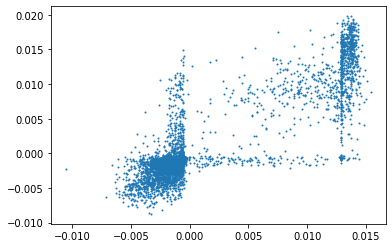

In [20]:
plt.scatter(clean_embed[0][:,0], clean_embed[1][:,0], s=1)
plt.show()

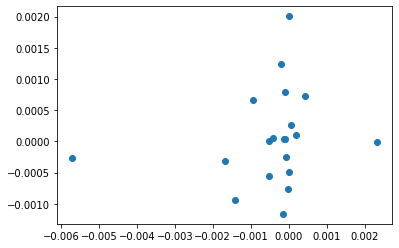

In [270]:
plt.scatter(clean_embed[0][0], corrupt_embed[1][0])
plt.show()

## Correlation between CCA dimensions for a single sample

In [12]:
def avgcorr(num, ds1, ds2):
    sums = []
    for i in range(num):
        for j in range(4):
            for k in range(4):
                sums.append(np.corrcoef(ds1[j][i], ds2[k][i])[0,1])
    return sums

In [18]:
from scipy.stats import norm

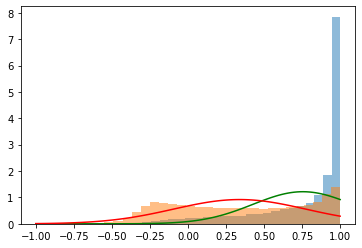

In [19]:
#clean_corr = avgcorr(10000, clean_embed, clean_embed)
#corrupt_corr = avgcorr(10000, clean_embed, corrupt_embed)
clean_mean, clean_std = (np.mean(clean_corr), np.std(clean_corr))
corrupt_mean, corrupt_std = (np.mean(corrupt_corr), np.std(corrupt_corr))
plt.hist(clean_corr, bins=30, alpha=0.5, density=True)
plt.hist(corrupt_corr, bins=30, alpha=0.5, density=True)
x = np.linspace(-1, 1, 100)
plt.plot(x, norm.pdf(x, clean_mean, clean_std), c='green')
plt.plot(x, norm.pdf(x, corrupt_mean, corrupt_std), c='red')
plt.show()

In [16]:
clean_mean, clean_std = (np.mean(clean_corr), np.std(clean_corr))
corrupt_mean, corrupt_std = (np.mean(corrupt_corr), np.std(corrupt_corr))

In [10]:
def show(image):
    full_image = np.zeros((28,28))
    full_image[0:14,0:14] = image[0]
    full_image[0:14,14:] = image[1]
    full_image[14:,0:14] = image[2]
    full_image[14:,14:] = image[3]
    plt.imshow(full_image, cmap='gray')

def reconstruct(image):
    full_image = np.zeros((28,28))
    full_image[0:14,0:14] = image[0]
    full_image[0:14,14:] = image[1]
    full_image[14:,0:14] = image[2]
    full_image[14:,14:] = image[3]
    return full_image

In [5]:
for data, label in dl_test_ad:
    samples = data

In [20]:
sample = [samples[mod][1,:,:,:] for mod in range(4)]

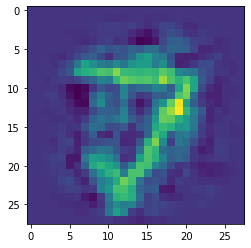

In [222]:

plt.imshow(reconstruct(noises[2](sample, 1)))

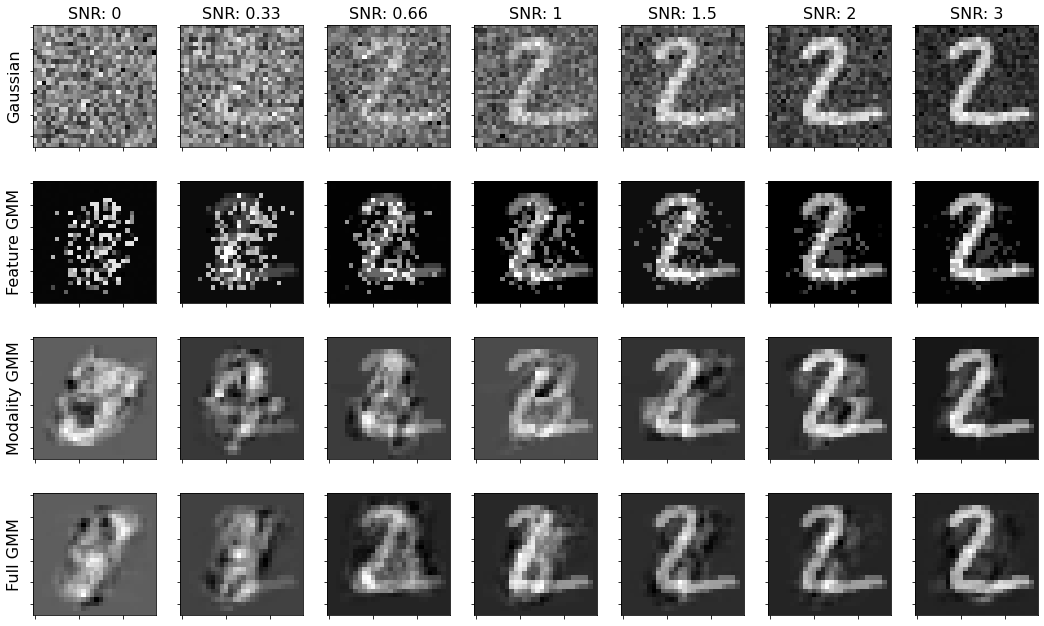

In [24]:
snrs = [0,0.33,0.66,1,1.5,2,3]
components = 9
# noises = [lambda data, snr: utils.noise.add_gaussian_noise(data, snr)]
# feature_noise = utils.noise.GMMNoise(dl_train_ad, components)
# noises.append(lambda data, snr: feature_noise.add_noise(data, snr=snr))
# mod_noise = utils.noise.ModGMMNoise(dl_train_ad, components)
# noises.append(lambda data, snr: mod_noise.add_noise(data, snr=snr))
# full_noise = utils.noise.FullGMMNoise(dl_train_ad, components)
# noises.append(lambda data, snr: full_noise.add_noise(data, snr=snr))
models = ['Gaussian', 'Feature GMM', 'Modality GMM', 'Full GMM']
fig, ax = plt.subplots(len(noises), len(snrs), sharex=True, sharey=True, figsize=(18,11))
for row, noise in enumerate(noises):
    ax[row,0].set_ylabel(models[row], fontsize=16)
    for col, snr in enumerate(snrs):
        if row == 0:
            ax[row,col].set_title('SNR: {}'.format(snr), fontsize=16)
        ax[row,col].imshow(reconstruct(noise(sample, snr)), cmap='gray')
        ax[row,col].set_xticklabels([])
        ax[row,col].set_yticklabels([])

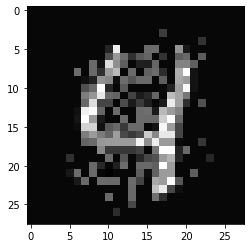

In [210]:
show_noise = lambda data, modality: noise_gen.add_noise(data, snr=1.5, modality=modality) # noise and image weighted equally
show(show_noise([mod[4,:,:] for mod in samples], modality=[0,1,2,3]))

## Train anomaly detector

In [21]:
window_size = 30

In [99]:
reload(dgcca.anomaly_detection)

<module 'dgcca.anomaly_detection' from 'c:\\Users\\harry\\Documents\\Work\\Dissertation\\robust-mm\\dgcca\\anomaly_detection.py'>

In [46]:
reload(dgcca.dgcca)

<module 'dgcca.dgcca' from 'c:\\Users\\harry\\Documents\\Work\\Dissertation\\robust-mm\\dgcca\\dgcca.py'>

Getting data embeddings...
Getting noise embeddings...
Computing (2,3) threshold: 100%|██████████| 6/6.0 [00:14<00:00,  2.46s/it]


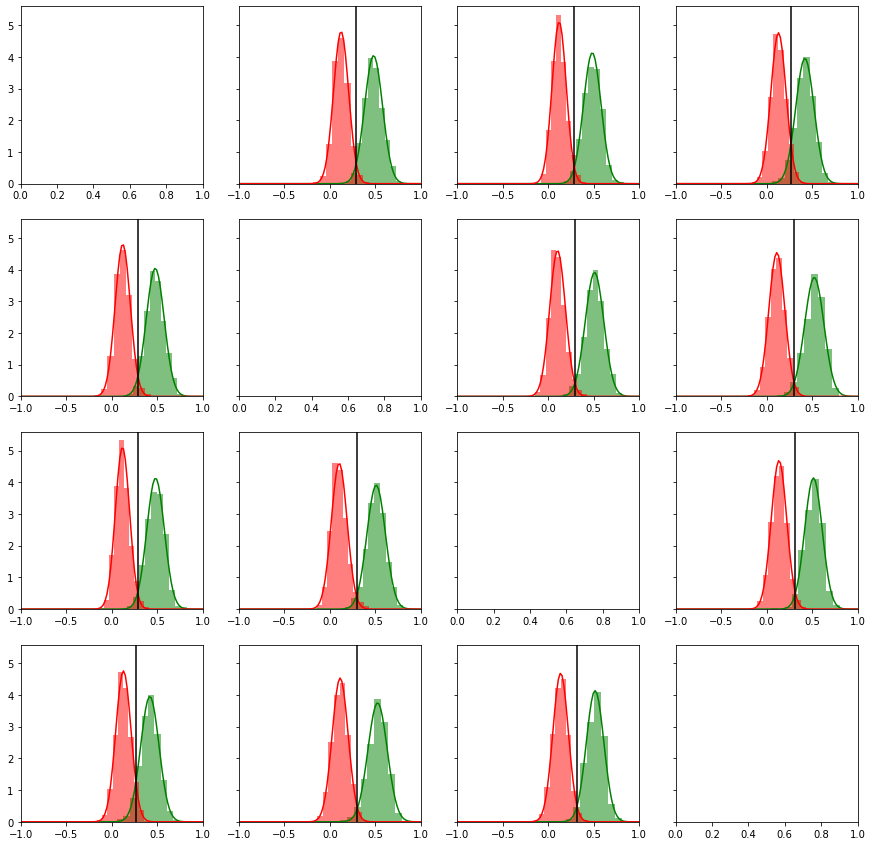

In [100]:
detector = dgcca.anomaly_detection.CcaAnomalyDetector(cca)

fig = detector.train(clean, corrupt, stride='auto', window=window_size, plot=True, method='intersection', method_param=0.01, classifier='delta')

In [96]:
np.sum(detector.type_1)/6

0.02801655803072736

In [97]:
np.sum(detector.type_2)/6

0.022586154934261176

In [177]:
dl_test_ad_batch = torch.utils.data.DataLoader(ds_test, batch_size=30)

In [178]:
count = 0
for data, label in dl_test_ad_batch:
    data = noise_gen.add_noise(data, 0.3, [1])
    embedded = [mod.detach().double() for mod in classifier(data, heads=True)]
    corrs = cca.get_corrs(embedded)
    count += 1
    if count == 1:
        break

In [179]:
deltas = corrs - detector.thresholds
deltas

array([[ 0.        , -0.30656105,  0.16523699,  0.13974029],
       [-0.30656105,  0.        , -0.29786235, -0.21275194],
       [ 0.16523699, -0.29786235,  0.        ,  0.23796452],
       [ 0.13974029, -0.21275194,  0.23796452,  0.        ]])

<ipython-input-184-ec9686338360>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,1,2,3,4])
<ipython-input-184-ec9686338360>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,1,2,3,4])


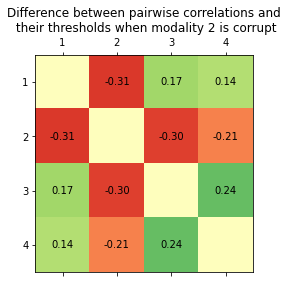

In [184]:
fig, ax = plt.subplots()  
ax.matshow(deltas, cmap='RdYlGn', norm=colors.TwoSlopeNorm(vmin=-0.4, vcenter=0, vmax=0.4))
ax.set_title('Difference between pairwise correlations and\n their thresholds when modality 2 is corrupt')
ax.set_xticklabels([0,1,2,3,4])
ax.set_yticklabels([0,1,2,3,4])
for (i, j), z in np.ndenumerate(deltas):
    if i != j:
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

In [15]:
def eval(data, detector, noise, num_corrupt=0, window=20, grace=0):
    classifier.eval()
    tp_pred, tn_pred, fp_pred, fn_pred, tp_ind, tn_ind, fp_ind, fn_ind = (0,0,0,0,0,0,0,0)
    with tqdm.auto.tqdm(total=len(range(0, len(data[0])-window, window))) as pbar:
        for i in range(0, len(data[0])-window, window):
            clean = np.ones(len(data))
            corrupt = np.random.default_rng().choice(len(data), size=num_corrupt, replace=False)
            clean[corrupt] = 0
            corrupt_data = noise([mod[i:i+window,:].numpy() for mod in data], corrupt)
            corrupt_data = [torch.FloatTensor(mod) for mod in corrupt_data]

            embedding = classifier(corrupt_data, heads=True)

            pred, individual = detector.detect_anomalies([mod.double() for mod in embedding], grace=grace, evaluating=True)

            for j in range(0,4):
                for k in range(j+1,4):
                    if j in corrupt or k in corrupt:
                        if not individual[j,k]:
                            tn_ind += 1
                        else:
                            fp_ind += 1
                    else:
                        if individual[j,k]:
                            tp_ind += 1
                        else:
                            fn_ind += 1
                        
            tp_pred += ((clean == pred) & (pred == True)).sum()
            tn_pred += ((clean == pred) & (pred == False)).sum()
            fp_pred += ((clean != pred) & (pred == True)).sum()
            fn_pred += ((clean != pred) & (pred == False)).sum()

            pbar.update(1)
            pbar.set_description('Prediction accuracy: {:.2%} | Individual accuracy: {:.2%} '.format((tp_pred+tn_pred)/(4*(1+(i/window))), (tp_ind+tn_ind)/(6*(1+(i/window)))))
    return np.array([[tp_pred, tn_pred, fp_pred, fn_pred],
                     [tp_ind, tn_ind, fp_ind, fn_ind]])

test_noise = lambda data, modality: noise_gen.add_noise(data, snr=snr, modality=modality)

In [54]:
noise_gen = utils.noise.GMMNoise(dl_train_ad, 5)

Generating GMM for dataset: 100%|██████████| 4/4 [00:59<00:00, 14.79s/it]


In [17]:
import utils.evaluate

In [133]:
reload(utils.noise)

<module 'utils.noise' from 'c:\\Users\\harry\\Documents\\Work\\Dissertation\\robust-mm\\utils\\noise.py'>

In [36]:
dl_test_ad_1 = torch.utils.data.DataLoader(ds_test, batch_size=1)

In [37]:
sample = next(iter(dl_test_ad_1))[0]

In [142]:
modnoise = utils.noise.ModGMMNoise(dl_train_ad, 9)

torch.Size([10000, 1, 14, 14])
(10000, 196)
Fitting GMM to dataset
Initialization 0
  Iteration 10	 time lapse 10.08674s	 ll change 0.26063
  Iteration 20	 time lapse 8.86327s	 ll change 0.03783
  Iteration 30	 time lapse 8.34696s	 ll change 0.00264
Initialization converged: True	 time lapse 29.86859s	 ll 716.77130
torch.Size([10000, 1, 14, 14])
(10000, 196)
Fitting GMM to dataset
Initialization 0
  Iteration 10	 time lapse 10.25506s	 ll change 0.59786
  Iteration 20	 time lapse 9.53721s	 ll change 0.02028
Initialization converged: True	 time lapse 25.45412s	 ll 577.67133
torch.Size([10000, 1, 14, 14])
(10000, 196)
Fitting GMM to dataset
Initialization 0
  Iteration 10	 time lapse 10.07106s	 ll change 0.61464
  Iteration 20	 time lapse 9.44173s	 ll change 0.02871
Initialization converged: True	 time lapse 25.38816s	 ll 579.98789
torch.Size([10000, 1, 14, 14])
(10000, 196)
Fitting GMM to dataset
Initialization 0
  Iteration 10	 time lapse 10.01009s	 ll change 0.27728
Initialization conv

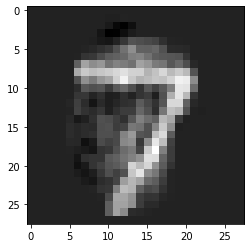

In [161]:
plt.imshow(reconstruct(modnoise, smap=gra.add_noise(sample, snr=2)), cmap='gray')

In [93]:
noisy[1].shape

torch.Size([1, 1, 14, 14])

In [232]:
reload(utils.evaluate)

<module 'utils.evaluate' from 'c:\\Users\\harry\\Documents\\Work\\Dissertation\\robust-mm\\utils\\evaluate.py'>

In [233]:
test_noise = lambda data, modality: fullnoise.add_noise(data, snr=snr, modality=modality)
for data, label in dl_test_ad:
    utils.evaluate.eval_both(classifier, data, label, detector, test_noise, num_corrupt=2, window=window_size, grace=0)

Prediction accuracy: 52.42% | Individual accuracy: 40.86% | Raw accuracy: 67.74% | Cleaned accuracy: 96.77% | AD cleaned accuracy: 93.55%:   0%|          | 31/9999 [00:28<2:33:06,  1.09it/s]


KeyboardInterrupt: 

In [60]:
classifier = utils.mm_mnist.MM_Classifier(4, (1,14,14), dropout=0.2, moddrop=0, activation=torch.tanh)
classifier.load_state_dict(torch.load('output/mm_mnist.pth'))

results = []
for dims in [5,10,20,40,60]:
    dim_results = []
    for window_size in [5,10,20,50,100]:
        print('======= dims: {} | window_size: {} ======='.format(dims, window_size))
        dim_results.append(pipeline(classifier, cca_dim=dims, snr=1, gmm_components=5, window_size=window_size, grace=0, noise_gen=noise_gen))
    results.append(dim_results)

00:04<00:00,  4.39s/it]
Getting data embeddings...
Getting noise embeddings...
Computing (2,3) threshold: 100%|██████████| 6/6.0 [00:08<00:00,  1.47s/it]
Prediction accuracy: 70.84% | Individual accuracy: 61.49% : 100%|██████████| 499/499 [03:19<00:00,  2.50it/s]
Embedding training set:: 100%|██████████| 391/391 [00:01<00:00, 282.45it/s]
Decomposed data matrix for view 0
Decomposed data matrix for view 1
Decomposed data matrix for view 2
Decomposed data matrix for view 3
Decomposed M_tilde / solved for G
Solved for U in view 0
Solved for U in view 1
Embedding:   0%|          | 0/1 [00:00<?, ?it/s]Solved for U in view 2
Solved for U in view 3
Embedding: 100%|██████████| 1/1 [00:05<00:00,  5.50s/it]
  0%|          | 0/6.0 [00:00<?, ?it/s]Getting data embeddings...
Getting noise embeddings...
Computing (2,3) threshold: 100%|██████████| 6/6.0 [00:12<00:00,  2.02s/it]
Prediction accuracy: 79.90% | Individual accuracy: 70.35% : 100%|██████████| 199/199 [01:24<00:00,  2.36it/s]
Embedding trai

In [487]:
for batch_size in [128]:
    for snr in [1.0]:
        for gmm_components in [5]:
            dims = []
            for window_size in [3,5,10,15,20,30,50,100,500]:
                windows = []
                for cca_dim in [5,10,15,20,30,50]:
                    for grace in [0]:
                        with open('output/{}_{}_{}_{}_{}_{}.npy'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                            windows.append(np.load(f))
                dims.append(np.stack(windows))


In [488]:
results = dims

In [5]:
def acc(raw, dim, corr, lines):
    res = []
    for i in range(len(lines)):
        res.append((raw[i][corr,dim,0]+raw[i][corr,dim,1])/np.sum(raw[i][corr,dim,:]))
    return res

In [6]:
def acc_window(res, window_idx, dim, corr, xs):
    data = [window[window_idx] for window in res]
    results = []
    for i in range(len(xs)):
        results.append((data[i][corr,dim,0]+data[i][corr,dim,1])/np.sum(data[i][corr,dim,:]))
    return results

In [8]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    dims = [5,10,15,20,30,50]
    for dim in range(len(dims)):
        ax[ax_idx].plot(range(len([3,5,10,15,20,30,50,100,500])), acc(results[dim], 0, ax_idx, [5,10,15,20,30,50]))
    ax[ax_idx].legend([5,10,15,20,30,50])
    ax[ax_idx].set_xticklabels([0,3,5,10,15,20,30,50,100,500])
    ax[ax_idx].set_xlabel('Number of samples')
    ax[ax_idx].set_ylabel('Accuracy')
#fig.title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (9,) and (6,)

<ipython-input-179-e1e8d7259f9f>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ax_idx].set_xticklabels([0,5,10,15,20,30,50])


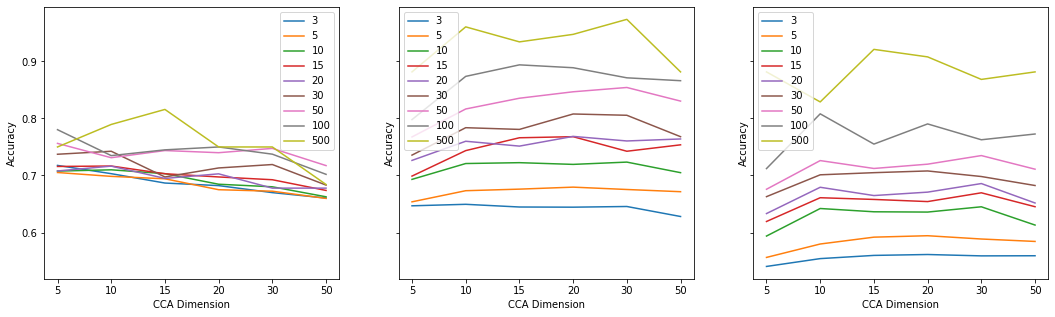

In [179]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    windows = [3,5,10,15,20,30,50,100,500]
    for window in range(len(windows)):
        ax[ax_idx].plot(range(len([5,10,15,20,30,50])), acc_window(results, window, 0, ax_idx))
    ax[ax_idx].legend(windows)
    ax[ax_idx].set_xticklabels([0,5,10,15,20,30,50])
    ax[ax_idx].set_xlabel('CCA Dimension')
    ax[ax_idx].set_ylabel('Accuracy')
    #ax.set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

In [491]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    dims = [5,10,15,20,30,50]
    for dim in range(len(dims)):
        ax[ax_idx].plot(range(len([3,5,10,15,20,30,50,100,500])), acc(results[dim], 1, ax_idx))
    ax[ax_idx].legend([5,10,15,20,30,50])
    ax[ax_idx].set_xticklabels([0,3,5,10,15,20,30,50,100,500])
    ax[ax_idx].set_xlabel('Number of samples')
    ax[ax_idx].set_ylabel('Accuracy')
#fig.title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

TypeError: acc() missing 1 required positional argument: 'lines'

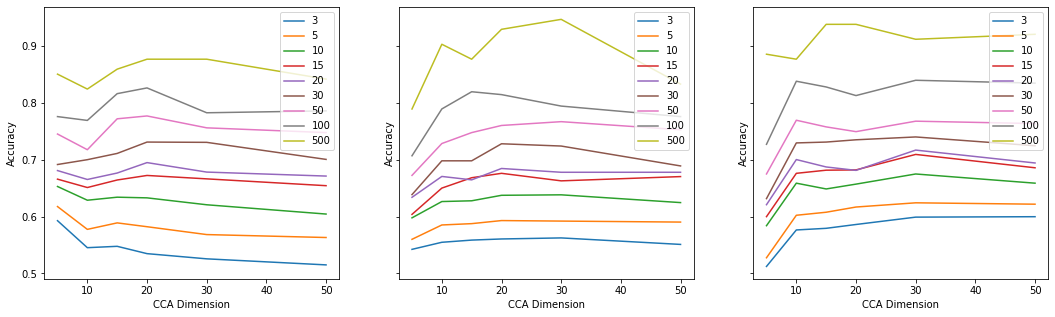

In [176]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    windows = [3,5,10,15,20,30,50,100,500]
    for window in range(len(windows)):
        ax[ax_idx].plot([5,10,15,20,30,50], acc_window(results, window, 1, ax_idx))
    ax[ax_idx].legend(windows)
    ax[ax_idx].set_xlabel('CCA Dimension')
    ax[ax_idx].set_ylabel('Accuracy')
    #ax.set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

In [ ]:
first_window = [3,5,10,15,20,30,50,100,500]
first_dim = [5,10,15,20,30,50]

In [3]:
for batch_size in [128]:
    noise = []
    for snr in [0.0,0.25,0.5,0.75,1.0,2.0]:
        gmm = []
        for gmm_components in [1,3,5,7,9]:
            for cca_dim in [15]:
                for window_size in [30]:
                    for grace in [0]:
                        with open('output/{}_{}_{}_{}_{}_{}.npy'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                            gmm.append(np.load(f))
        noise.append(np.stack(gmm))
results = noise

In [190]:
len(results)

6

<ipython-input-7-823d9af2c993>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ax_idx].set_xticklabels([0,1,' ',3,' ',5,' ',7,' ',9])


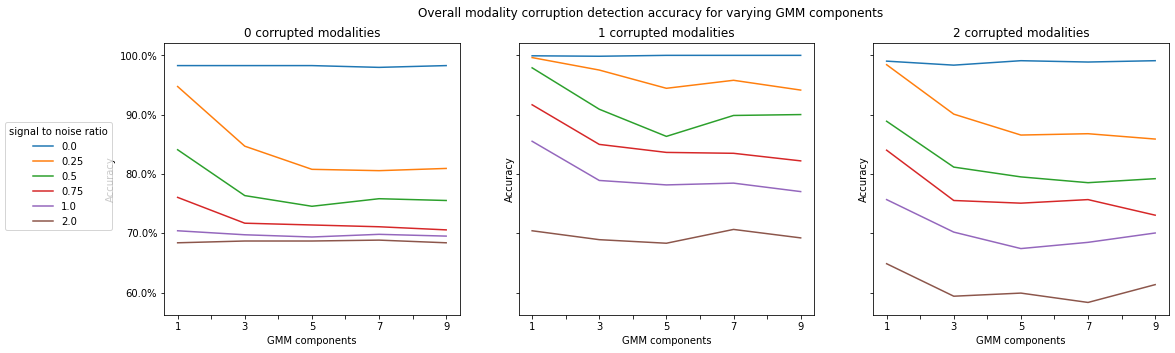

In [7]:
lines = [0.0,0.25,0.5,0.75,1.0,2.0]
xs = [1,3,5,7,9]

fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    for snr in range(len(lines)):
        ax[ax_idx].plot(xs, [100*el for el in acc(results[snr], 0, ax_idx, xs)])
    ax[ax_idx].yaxis.set_major_formatter(ticker.PercentFormatter())
    ax[ax_idx].set_xlabel('GMM components')
    ax[ax_idx].set_ylabel('Accuracy')
    ax[ax_idx].set_xticklabels([0,1,' ',3,' ',5,' ',7,' ',9])
    ax[ax_idx].set_title('{} corrupted modalities'.format(ax_idx))

fig.legend(lines, title='signal to noise ratio', loc='center left')
fig.suptitle('Overall modality corruption detection accuracy for varying GMM components')
plt.show()

In [29]:
def plots(results, lines, xs, xlabel, ylabel, legend, title):
    fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
    for ax_idx in range(3):
        for line in range(len(lines)):
            ax[ax_idx].plot(xs, [100*el for el in acc(results[line], 0, ax_idx, xs)])
        ax[ax_idx].yaxis.set_major_formatter(ticker.PercentFormatter())
        ax[ax_idx].set_xlabel(xlabel)
        ax[ax_idx].set_ylabel(ylabel)
        ax[ax_idx].set_xticklabels([0,1,' ',3,' ',5,' ',7,' ',9])
        ax[ax_idx].set_title('{} corrupted modalities'.format(ax_idx))

    fig.legend(lines, title=legend, loc='center left')
    fig.suptitle(title)
    plt.show()

<ipython-input-29-6067c4b9164a>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ax_idx].set_xticklabels([0,1,' ',3,' ',5,' ',7,' ',9])


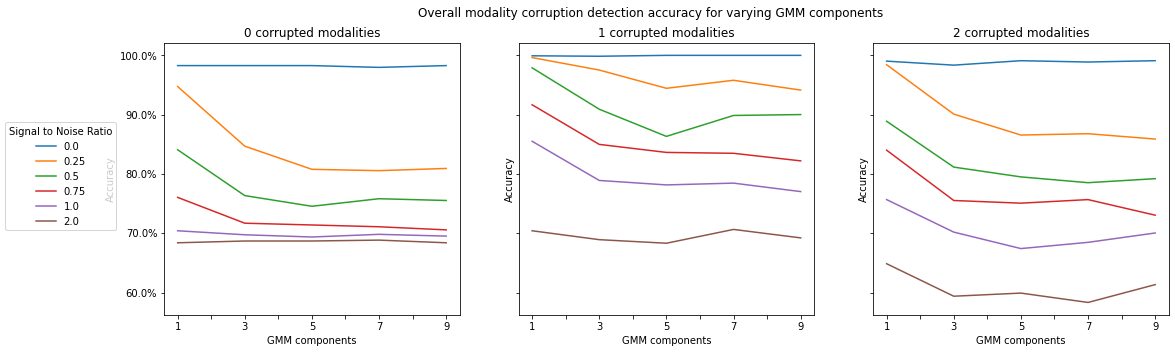

In [30]:
plots(results, [0.0,0.25,0.5,0.75,1.0,2.0], [1,3,5,7,9], 'GMM components', 'Accuracy', 'Signal to Noise Ratio', 'Overall modality corruption detection accuracy for varying GMM components')

In [9]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    windows = [3,5,10,15,20,30,50,100,500]
    for window in range(len(windows)):
        ax[ax_idx].plot(range(len([5,10,15,20,30,50])), acc_window(results, window, 0, ax_idx))
    ax[ax_idx].legend(windows)
    ax[ax_idx].set_xticklabels([0,5,10,15,20,30,50])
    ax[ax_idx].set_xlabel('CCA Dimension')
    ax[ax_idx].set_ylabel('Accuracy')
ax[1].set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

TypeError: acc_window() missing 1 required positional argument: 'xs'

In [27]:
def get_acc(results):
    return (results[0]+results[1])/np.sum(results)

In [464]:
acc = []
raw_acc = []
clean_acc = []
for batch_size in [128]:
    for x, snr in enumerate([0.0,0.25,0.5,0.75,1.0,2.0]):
        acc.append([])
        raw_acc.append([])
        clean_acc.append([])
        for gmm_components in [1,3,5,7,9]:
            for cca_dim in [15]:
                for window_size in [30]:
                    for grace in [0]:
                        try:
                            with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                                res = pickle.load(f)
                            acc[x].append([get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]])
                            raw_acc[x].append([res[ncorr]['raw'] for ncorr in [0,1,2]])
                            clean_acc[x].append([res[ncorr]['clean'] for ncorr in [0,1,2]])
                        except FileNotFoundError:
                            print('cant find {}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace))
                            acc[x].append([0 for ncorr in [0,1,2]])
                            raw_acc[x].append([0 for ncorr in [0,1,2]])
                            clean_acc[x].append([0 for ncorr in [0,1,2]])

In [465]:
acc

[[[0.9984984984984985, 1.0, 0.963963963963964],
  [0.9984984984984985, 1.0, 0.8213213213213213],
  [0.9864864864864865, 1.0, 0.722972972972973],
  [0.9864864864864865, 1.0, 0.8798798798798799],
  [0.9864864864864865, 1.0, 0.8168168168168168]],
 [[0.9707207207207207, 0.9984984984984985, 0.9804804804804805],
  [0.9459459459459459, 0.9992492492492493, 0.9414414414414415],
  [0.9429429429429429, 0.9962462462462462, 0.8738738738738738],
  [0.9309309309309309, 0.9977477477477478, 0.8993993993993994],
  [0.93993993993994, 1.0, 0.8663663663663663]],
 [[0.9091591591591591, 0.9827327327327328, 0.9279279279279279],
  [0.8963963963963963, 0.9887387387387387, 0.9429429429429429],
  [0.8881381381381381, 0.9902402402402403, 0.9361861861861862],
  [0.8911411411411412, 0.9917417417417418, 0.9294294294294294],
  [0.8836336336336337, 0.9902402402402403, 0.9376876876876877]],
 [[0.8633633633633634, 0.9669669669669669, 0.8753753753753754],
  [0.8536036036036037, 0.9737237237237237, 0.9204204204204204],
  [

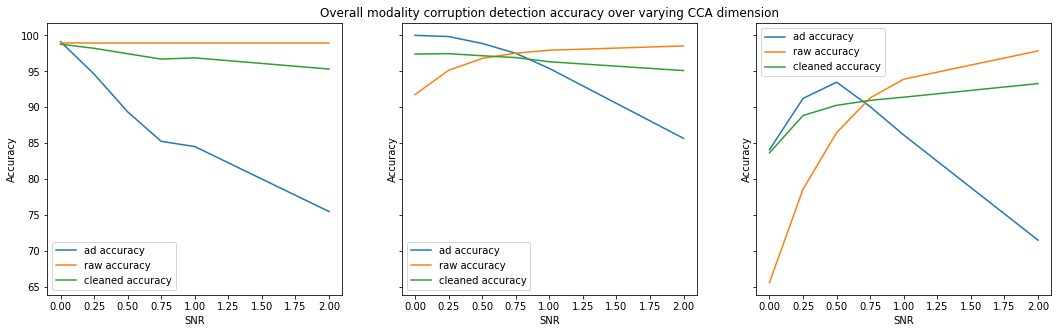

In [450]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot([0.0,0.25,0.5,0.75,1.0,2.0], [100*np.mean([acc[x][gmm][ax_idx] for gmm in range(5)]) for x in range(6)])
    ax[ax_idx].plot([0.0,0.25,0.5,0.75,1.0,2.0], [100*np.mean([raw_acc[x][gmm][ax_idx] for gmm in range(5)]) for x in range(6)])
    ax[ax_idx].plot([0.0,0.25,0.5,0.75,1.0,2.0], [100*np.mean([clean_acc[x][gmm][ax_idx] for gmm in range(5)]) for x in range(6)])
    ax[ax_idx].legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy'])
    ax[ax_idx].set_xlabel('SNR')
    ax[ax_idx].set_ylabel('Accuracy')
ax[1].set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

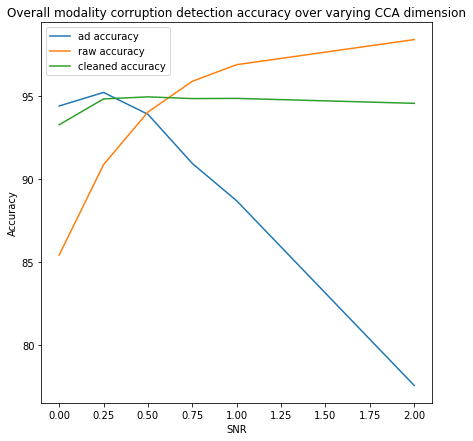

In [460]:
np.mean([acc[x][gmm][ax_idx] for gmm in range(5)])
fig, ax = plt.subplots(1,1, sharey=True, figsize=(7, 7))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*np.mean([acc[x][gmm][corr] for gmm in range(5)]) for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*np.mean([raw_acc[x][gmm][corr] for gmm in range(5)]) for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*np.mean([clean_acc[x][gmm][corr] for gmm in range(5)]) for x in range(6)] for corr in range(3)]), axis=0))
ax.legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy'])
ax.set_xlabel('SNR')
ax.set_ylabel('Accuracy')
ax.set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

In [82]:
def loadpkl(batch=[128], snrs=[1], gmms=[5], cca_dims=[15], window_sizes=[30], graces=[0], noise_type='gmm', thresh_method='intersection', suffix='', repeats=1 ,train_snr=-1):
    acc = []
    raw_acc = []
    clean_acc = []
    ad_clean_acc = []
    for batch_size in batch:
        for x, snr in enumerate(snrs):
            acc.append([])
            raw_acc.append([])
            clean_acc.append([])
            ad_clean_acc.append([])
            for gmm_components in gmms:
                for cca_dim in cca_dims:
                    for window_size in window_sizes:
                        for grace in graces:
                            sum_acc = np.array([0,0,0], dtype='float64')
                            sum_raw = np.array([0,0,0], dtype='float64')
                            sum_clean = np.array([0,0,0], dtype='float64')
                            sum_ad_clean = np.array([0,0,0], dtype='float64')
                            for repeat in range(repeats):
                                with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}_{}_{}{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace, noise_type, thresh_method, suffix, repeat, train_snr), 'rb') as f:
                                    res = pickle.load(f)
                                sum_acc += [get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                                sum_raw += [res[ncorr]['raw'] for ncorr in [0,1,2]]
                                sum_clean += [res[ncorr]['clean'] for ncorr in [0,1,2]]
                                sum_ad_clean += [res[ncorr]['ad_clean'] for ncorr in [0,1,2]]

                            acc[x].append(sum_acc/repeats)
                            raw_acc[x].append(sum_raw/repeats)
                            clean_acc[x].append(sum_clean/repeats)
                            ad_clean_acc[x].append(sum_ad_clean/repeats)
    return (acc, raw_acc, clean_acc, ad_clean_acc)

In [50]:
snrs = [0.0,0.25,0.5,0.75,1.0,2.0]
acc, raw_acc, clean_acc, ad_clean_acc = loadpkl(snrs=snrs, window_sizes=[30], thresh_method='noise_mean', repeats=5)

fig, ax = plt.subplots(1,1, sharey=True, figsize=(7, 7))
ax.plot(snrs, np.mean(np.array([[100*acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.plot(snrs, np.mean(np.array([[100*raw_acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.plot(snrs, np.mean(np.array([[100*clean_acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.plot(snrs, np.mean(np.array([[100*ad_clean_acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad cleaned accuracy'])
ax.set_xlabel('SNR')
ax.set_ylabel('Accuracy')
ax.set_title('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'output/cnn_moddrop_128_0.25_5_15_30_0_gmm_noise_mean_0.pkl'

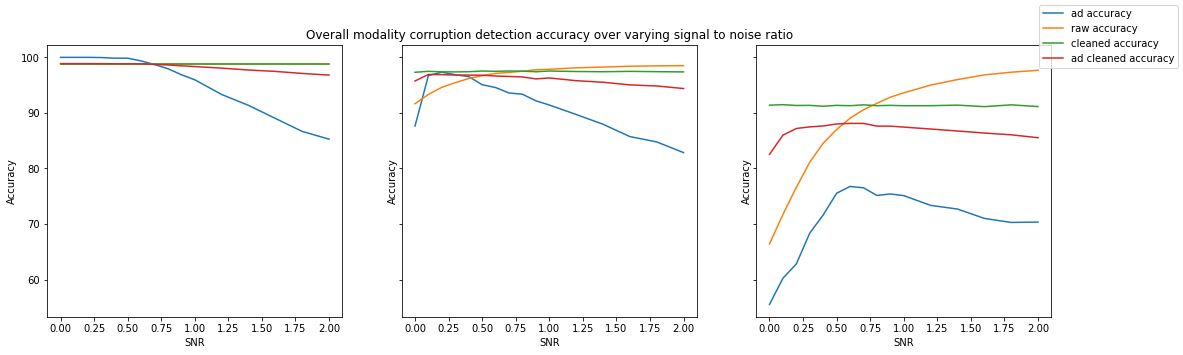

In [77]:
snrs = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4,1.6,1.8,2.0]
acc, raw_acc, clean_acc, ad_clean_acc = loadpkl(snrs=snrs, thresh_method='noise_mean', repeats=5, train_snr=1281.0)

fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot(snrs, [100*acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*raw_acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*clean_acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*ad_clean_acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].set_xlabel('SNR')
    ax[ax_idx].set_ylabel('Accuracy')
fig.legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad cleaned accuracy'])
ax[1].set_title('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

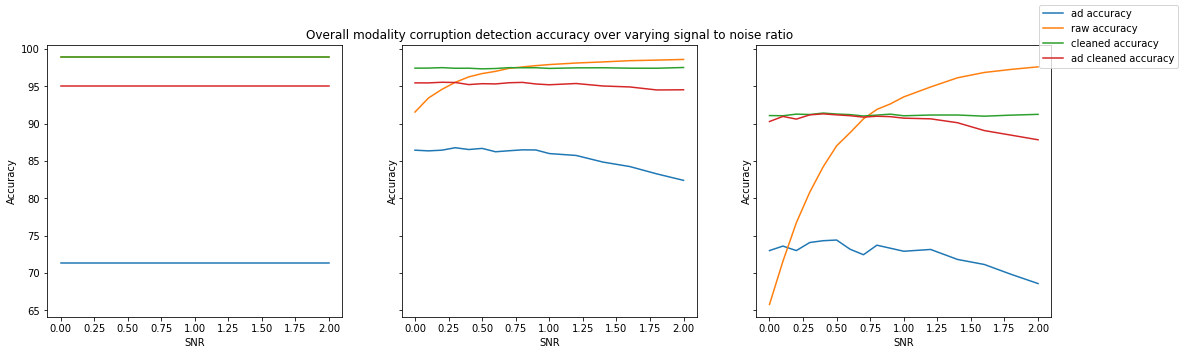

In [79]:
snrs = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4,1.6,1.8,2.0]
acc, raw_acc, clean_acc, ad_clean_acc = loadpkl(snrs=snrs, thresh_method='noise_mean', repeats=5, train_snr=1281.0)

fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot(snrs, [100*acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*raw_acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*clean_acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*ad_clean_acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].set_xlabel('SNR')
    ax[ax_idx].set_ylabel('Accuracy')
fig.legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad cleaned accuracy'])
ax[1].set_title('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

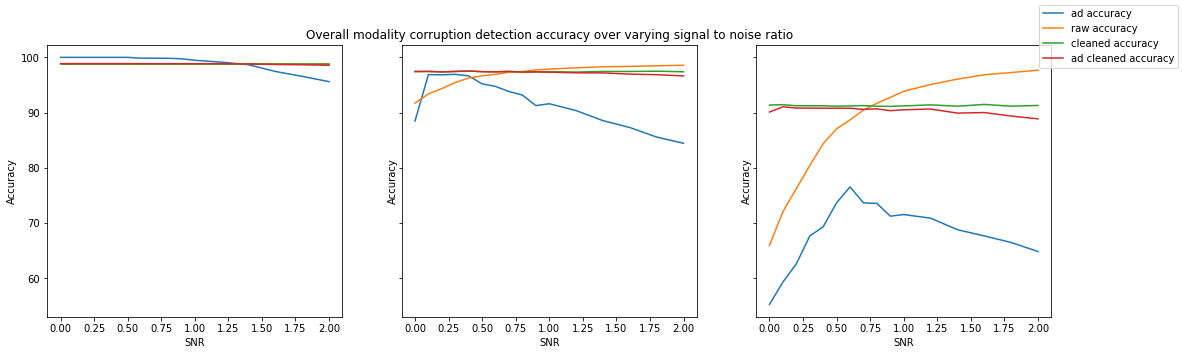

In [83]:
snrs = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4,1.6,1.8,2.0]
acc, raw_acc, clean_acc, ad_clean_acc = loadpkl(snrs=snrs, thresh_method='noise_mean', repeats=5, graces=[1], train_snr=1281.0)

fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot(snrs, [100*acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*raw_acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*clean_acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*ad_clean_acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].set_xlabel('SNR')
    ax[ax_idx].set_ylabel('Accuracy')
fig.legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad cleaned accuracy'])
ax[1].set_title('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

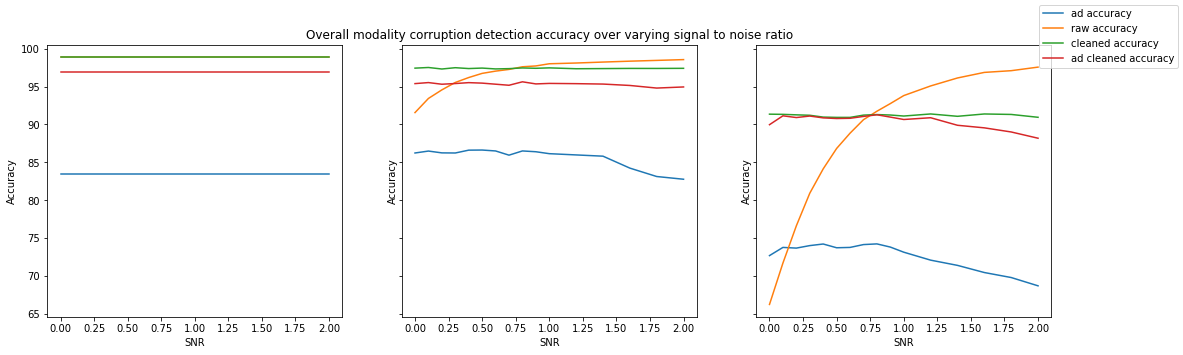

In [81]:
snrs = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4,1.6,1.8,2.0]
acc, raw_acc, clean_acc, ad_clean_acc = loadpkl(snrs=snrs, thresh_method='noise_mean', repeats=5, graces=[1], train_snr=1281.0)

fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot(snrs, [100*acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*raw_acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*clean_acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*ad_clean_acc[x][0][ax_idx] for x in range(len(snrs))])
    ax[ax_idx].set_xlabel('SNR')
    ax[ax_idx].set_ylabel('Accuracy')
fig.legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad cleaned accuracy'])
ax[1].set_title('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

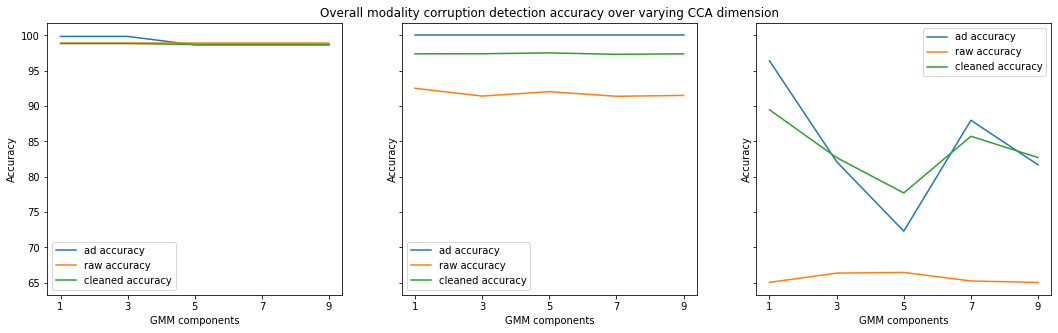

In [454]:
snr_idx = 0
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot([str(lab) for lab in [1,3,5,7,9]], [100*x[ax_idx] for x in acc[snr_idx]])
    ax[ax_idx].plot([str(lab) for lab in [1,3,5,7,9]], [100*x[ax_idx] for x in raw_acc[snr_idx]])
    ax[ax_idx].plot([str(lab) for lab in [1,3,5,7,9]], [100*x[ax_idx] for x in clean_acc[snr_idx]])
    ax[ax_idx].legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy'])
    ax[ax_idx].set_xlabel('GMM components')
    ax[ax_idx].set_ylabel('Accuracy')
ax[1].set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

In [499]:
acc = []
raw_acc = []
clean_acc = []
ad_clean_acc = []
for batch_size in [128]:
    for x, snr in enumerate([0.0,0.25,0.5,0.75,1.0,2.0]):
        acc.append([])
        raw_acc.append([])
        clean_acc.append([])
        ad_clean_acc.append([])
        for gmm_components in [5]:
            for cca_dim in [15]:
                for window_size in [100]:
                    for grace in [0]:
                        try:
                            with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}_gmm.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                                res = pickle.load(f)
                            acc[x].append([get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]])
                            raw_acc[x].append([res[ncorr]['raw'] for ncorr in [0,1,2]])
                            clean_acc[x].append([res[ncorr]['clean'] for ncorr in [0,1,2]])
                            ad_clean_acc[x].append([res[ncorr]['ad_clean'] for ncorr in [0,1,2]])
                        except FileNotFoundError:
                            print('cant find {}_{}_{}_{}_{}_{}_gaussian.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace))
                            acc[x].append([0 for ncorr in [0,1,2]])
                            raw_acc[x].append([0 for ncorr in [0,1,2]])
                            clean_acc[x].append([0 for ncorr in [0,1,2]])
                            ad_clean_acc[x].append([0 for ncorr in [0,1,2]])

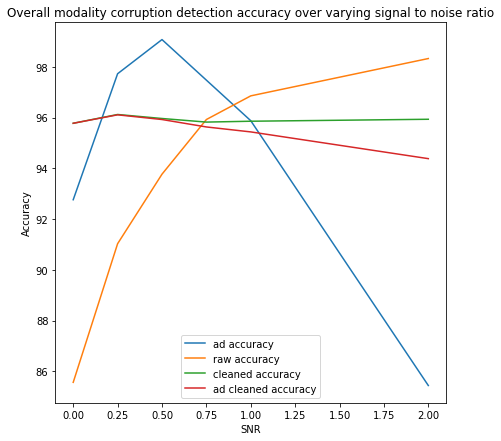

In [500]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(7, 7))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*raw_acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*clean_acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*ad_clean_acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad cleaned accuracy'])
ax.set_xlabel('SNR')
ax.set_ylabel('Accuracy')
ax.set_title('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

In [497]:
acc = []
raw_acc = []
clean_acc = []
for batch_size in [128]:
    for x, snr in enumerate([0.0,0.25,0.5,0.75,1.0,2.0]):
        acc.append([])
        raw_acc.append([])
        clean_acc.append([])
        for gmm_components in [1,3,5,7,9]:
            for cca_dim in [15]:
                for window_size in [30]:
                    for grace in [0]:
                        try:
                            with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                                res = pickle.load(f)
                            acc[x].append([get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]])
                            raw_acc[x].append([res[ncorr]['raw'] for ncorr in [0,1,2]])
                            clean_acc[x].append([res[ncorr]['clean'] for ncorr in [0,1,2]])
                        except FileNotFoundError:
                            print('cant find {}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace))
                            acc[x].append([0 for ncorr in [0,1,2]])
                            raw_acc[x].append([0 for ncorr in [0,1,2]])
                            clean_acc[x].append([0 for ncorr in [0,1,2]])

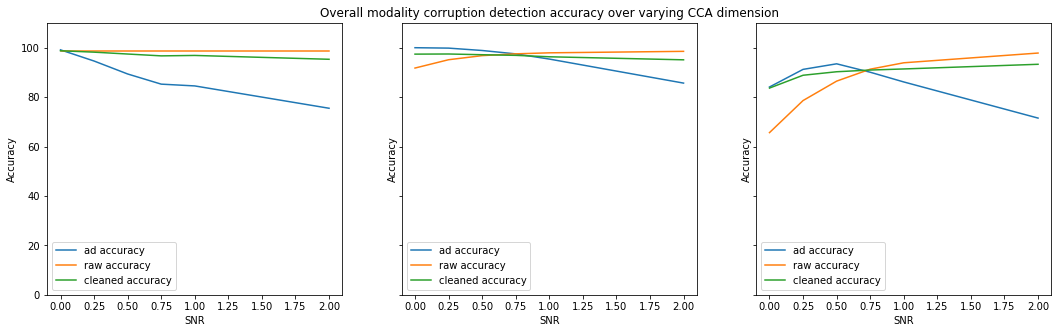

In [498]:
np.mean([acc[x][gmm][ax_idx] for gmm in range(5)])
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot([0.0,0.25,0.5,0.75,1.0,2.0], [100*np.mean([acc[x][gmm][ax_idx] for gmm in range(5)]) for x in range(6)])
    ax[ax_idx].plot([0.0,0.25,0.5,0.75,1.0,2.0], [100*np.mean([raw_acc[x][gmm][ax_idx] for gmm in range(5)]) for x in range(6)])
    ax[ax_idx].plot([0.0,0.25,0.5,0.75,1.0,2.0], [100*np.mean([clean_acc[x][gmm][ax_idx] for gmm in range(5)]) for x in range(6)])
    ax[ax_idx].legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy'])
    ax[ax_idx].set_xlabel('SNR')
    ax[ax_idx].set_ylabel('Accuracy')
plt.ylim(0,110)
ax[1].set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

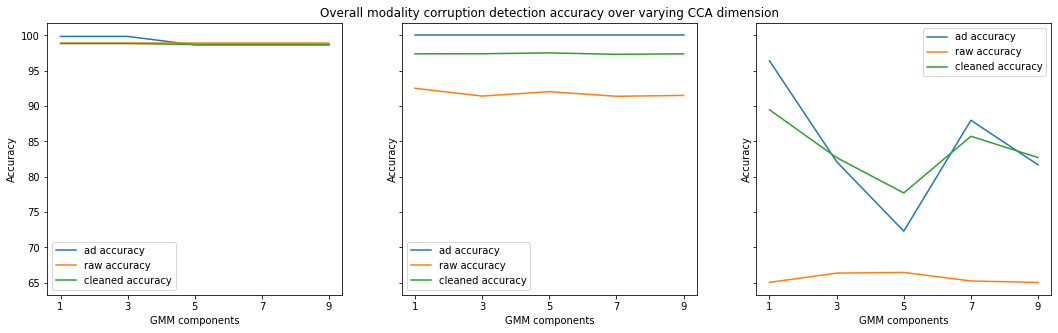

In [442]:
snr_idx = 5
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot([str(lab) for lab in [1,3,5,7,9]], [100*x[ax_idx] for x in acc[snr_idx]])
    ax[ax_idx].plot([str(lab) for lab in [1,3,5,7,9]], [100*x[ax_idx] for x in raw_acc[snr_idx]])
    ax[ax_idx].plot([str(lab) for lab in [1,3,5,7,9]], [100*x[ax_idx] for x in clean_acc[snr_idx]])
    ax[ax_idx].legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy'])
    ax[ax_idx].set_xlabel('GMM components')
    ax[ax_idx].set_ylabel('Accuracy')
ax[1].set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

In [57]:
noise_type = 'gmm'
suffix = ''
seed=0
train_snr=0.65 
repeats=3   
acc = []
raw_acc = []
clean_acc = []
ad_clean_acc = []
for batch_size in [128]:
    for x, thresh_method in enumerate([0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]):
        acc.append([])
        raw_acc.append([])
        clean_acc.append([])
        ad_clean_acc.append([])
        for snr in [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]:
            for gmm_components in [5]:
                for cca_dim in [15]:
                    for window_size in [30]:
                        for grace in [0]:
                            sum_acc = np.array([0,0,0], dtype='float64')
                            sum_raw = np.array([0,0,0], dtype='float64')
                            sum_clean = np.array([0,0,0], dtype='float64')
                            sum_ad_clean = np.array([0,0,0], dtype='float64')
                            for repeat in range(repeats):
                                with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}_{}_{}{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace, noise_type, thresh_method, suffix, repeat, train_snr), 'rb') as f:
                                    res = pickle.load(f)
                                sum_acc += [get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                                sum_raw += [res[ncorr]['raw'] for ncorr in [0,1,2]]
                                sum_clean += [res[ncorr]['clean'] for ncorr in [0,1,2]]
                                sum_ad_clean += [res[ncorr]['ad_clean'] for ncorr in [0,1,2]]
                            acc[x].append(sum_acc/repeats)
                            raw_acc[x].append(sum_raw/repeats)
                            clean_acc[x].append(sum_clean/repeats)
                            ad_clean_acc[x].append(sum_ad_clean/repeats)


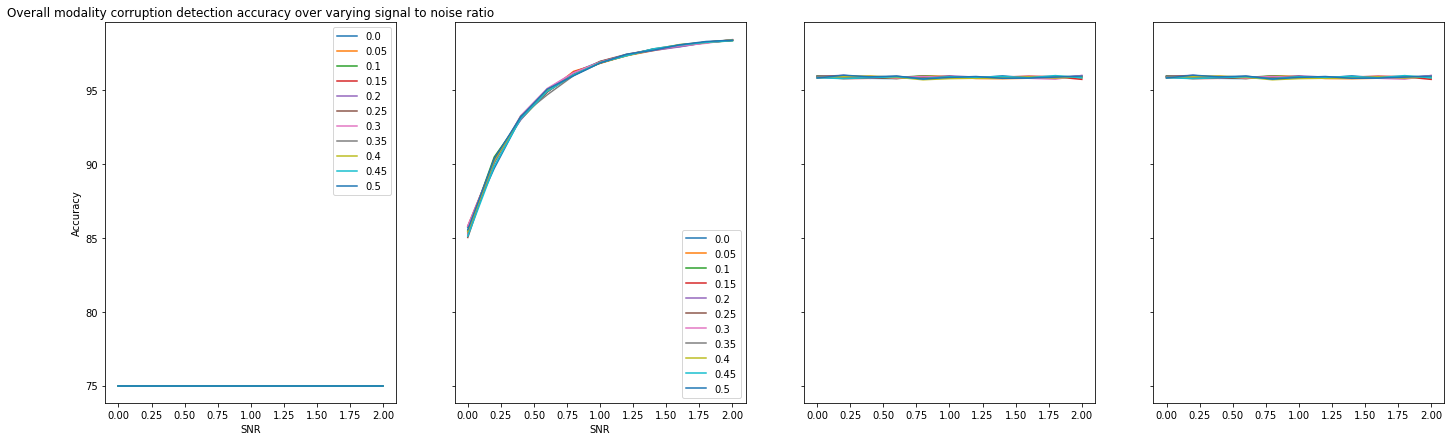

In [61]:
fig, ax = plt.subplots(1,4, sharey=True, figsize=(24,7))
threshes = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
snrs = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
for line in range(11):
    ax[0].plot(snrs, np.mean(np.array([[100*acc[line][x][corr] for x in range(11)]for corr in range(3)]), axis=0))
    ax[1].plot(snrs, np.mean(np.array([[100*raw_acc[line][x][corr] for x in range(11)]for corr in range(3)]), axis=0))
    ax[2].plot(snrs, np.mean(np.array([[100*clean_acc[line][x][corr] for x in range(11)]for corr in range(3)]), axis=0))
    ax[3].plot(snrs, np.mean(np.array([[100*ad_clean_acc[line][x][corr] for x in range(11)]for corr in range(3)]), axis=0))
#ax.plot(threshes, np.mean(np.array([[100*acc[x][0][corr] for x in range(11)] for corr in range(3)]), axis=0))
#ax.plot(threshes, np.mean(np.array([[100*raw_acc[x][0][corr] for x in range(11)] for corr in range(3)]), axis=0))
#ax.plot(threshes, np.mean(np.array([[100*clean_acc[0][x][corr] for x in range(11)] for corr in range(3)]), axis=0))
#ax.plot(threshes, np.mean(np.array([[100*ad_clean_acc[0][x][corr] for x in range(11)] for corr in range(3)]), axis=0))
ax[0].legend(threshes)#['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad cleaned accuracy'])
ax[0].set_xlabel('SNR')
ax[1].legend(threshes)#['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad cleaned accuracy'])
ax[1].set_xlabel('SNR')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

In [83]:
noise_type = 'gmm'
suffix = ''
seed=0
train_snr=0.65 
repeats=5   
acc = []
raw_acc = []
clean_acc = []
ad_clean_acc = []
fp = []
fn = []
thresh_method = 'intersection'
for batch_size in [128]:
    for x, round_func in enumerate(['none', 'ceiling', 'round', 'floor', 'delta', 'prob']):
        acc.append([])
        raw_acc.append([])
        clean_acc.append([])
        ad_clean_acc.append([])
        fp.append([])
        fn.append([])
        for snr in [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]:
            for gmm_components in [5]:
                for cca_dim in [15]:
                    for window_size in [30]:
                        for grace in [0]:
                            sum_acc = np.array([0,0,0], dtype='float64')
                            sum_raw = np.array([0,0,0], dtype='float64')
                            sum_clean = np.array([0,0,0], dtype='float64')
                            sum_ad_clean = np.array([0,0,0], dtype='float64')
                            sum_fp = np.array([0,0,0], dtype='float64')
                            sum_fn = np.array([0,0,0], dtype='float64')
                            for repeat in range(repeats):
                                with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}_{}_{}{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace, noise_type, thresh_method, suffix, repeat, snr, round_func), 'rb') as f:
                                    res = pickle.load(f)
                                sum_acc += [get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                                sum_raw += [res[ncorr]['raw'] for ncorr in [0,1,2]]
                                sum_clean += [res[ncorr]['clean'] for ncorr in [0,1,2]]
                                sum_ad_clean += [res[ncorr]['ad_clean'] for ncorr in [0,1,2]]
                                sum_fp += [res[ncorr]['ad'][0,2]/np.sum(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                                sum_fn += [res[ncorr]['ad'][0,3]/np.sum(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                            acc[x].append(sum_acc/repeats)
                            raw_acc[x].append(sum_raw/repeats)
                            clean_acc[x].append(sum_clean/repeats)
                            ad_clean_acc[x].append(sum_ad_clean/repeats)
                            fp[x].append(sum_fp/(repeats))
                            fn[x].append(sum_fn/(repeats))


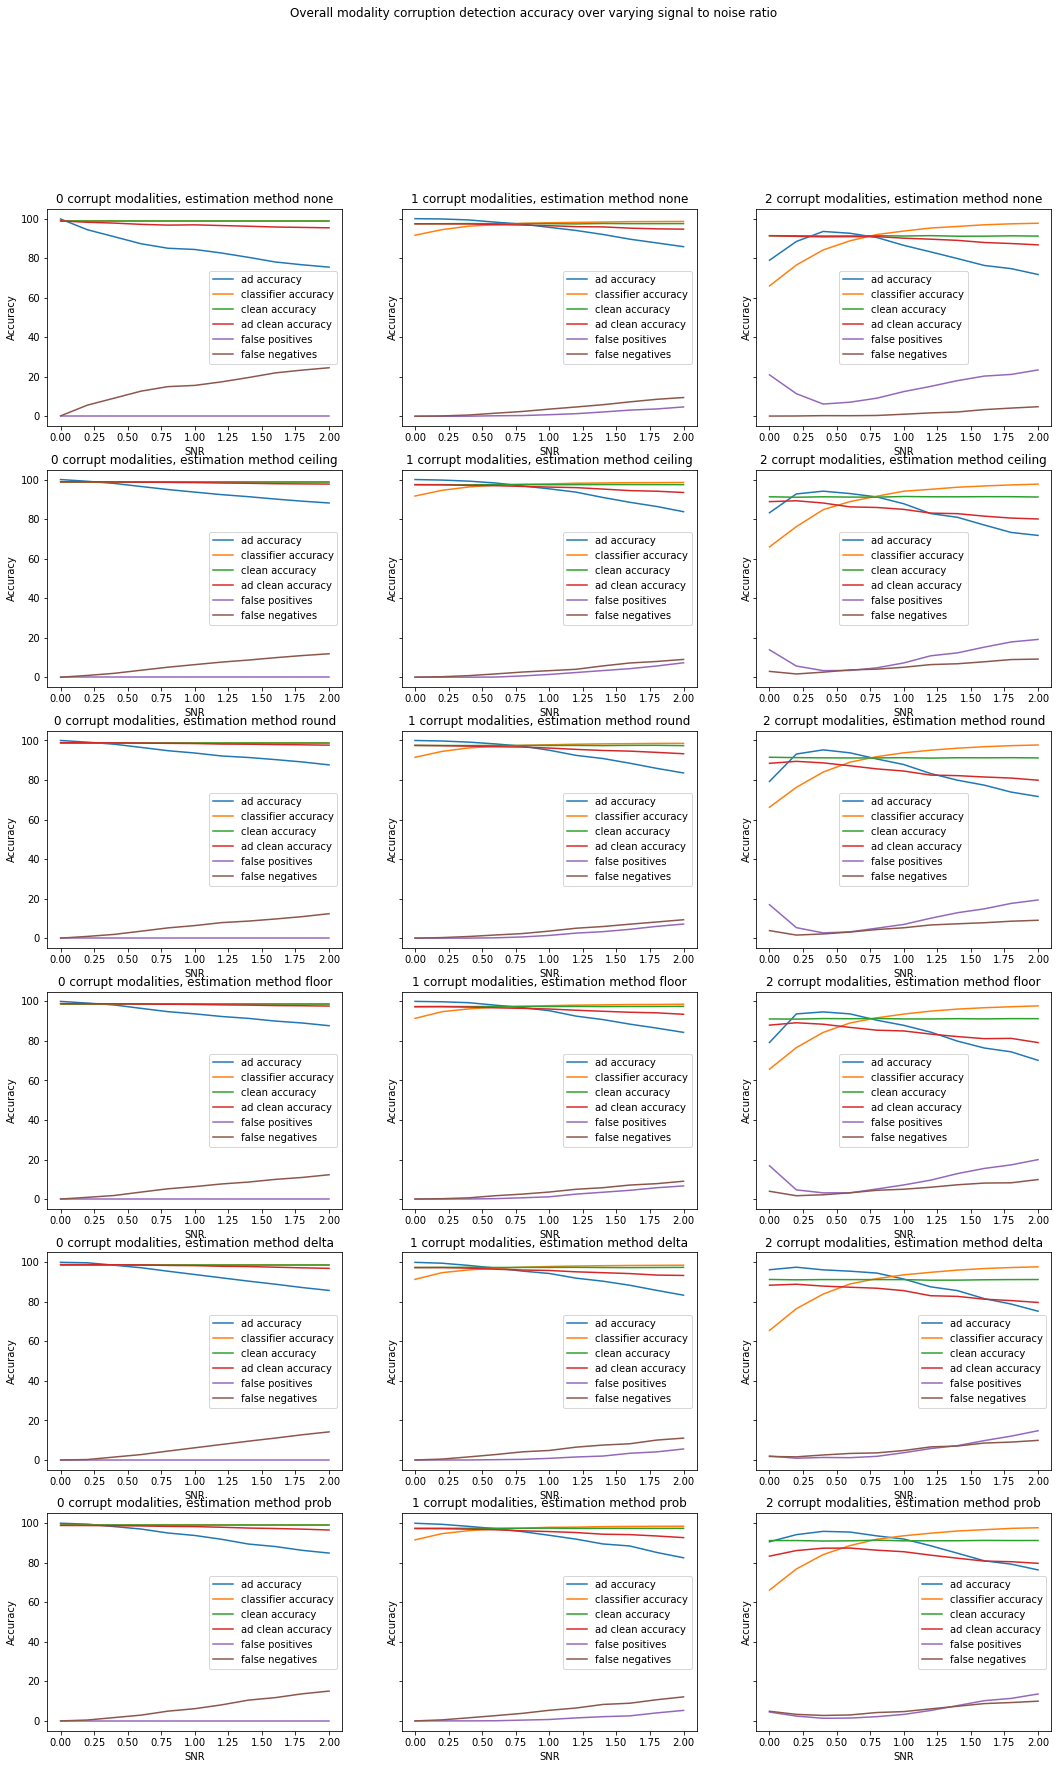

In [84]:
fig, ax = plt.subplots(6,3, sharey=True, figsize=(18,28))
rounds = ['none', 'ceiling', 'round', 'floor', 'delta', 'prob']
snrs = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]

for row, rounding in enumerate(rounds):
    for corrupt in range(3):
        for metric in [acc, raw_acc, clean_acc, ad_clean_acc, fp, fn]:
            ax[row, corrupt].plot(snrs, [100*metric[row][x][corrupt] for x in range(11)])
        ax[row, corrupt].legend(['ad accuracy', 'classifier accuracy', 'clean accuracy', 'ad clean accuracy', 'false positives', 'false negatives'])
        ax[row, corrupt].set_xlabel('SNR')
        ax[row, corrupt].set_ylabel('Accuracy')
        ax[row, corrupt].set_title('{} corrupt modalities, estimation method {}'.format(corrupt, rounding))
plt.suptitle('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

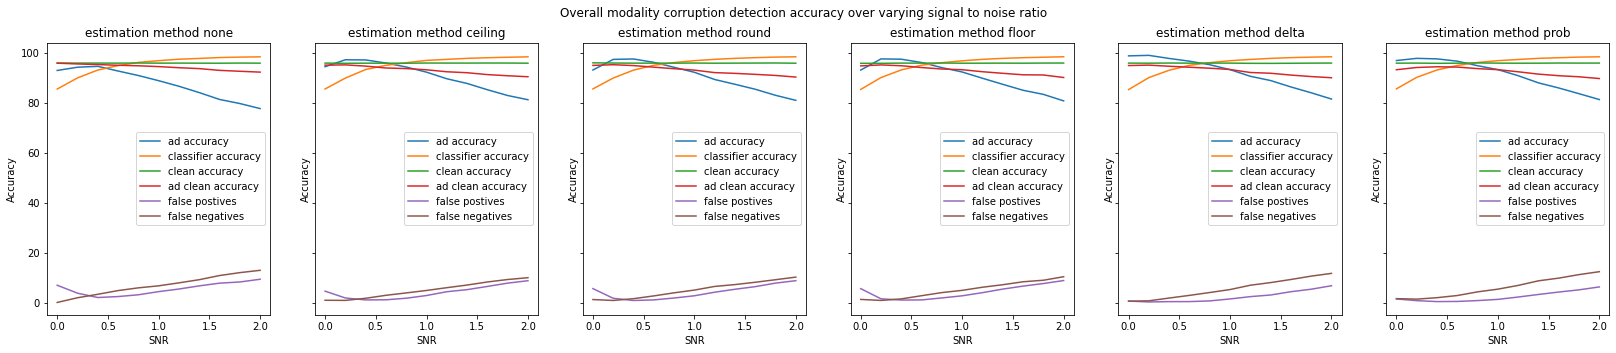

In [85]:
fig, ax = plt.subplots(1, 6, sharey=True, figsize=(28,5))
rounds = ['none', 'ceiling', 'round', 'floor', 'delta', 'prob']
snrs = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]

for row, rounding in enumerate(rounds):
    for metric in [acc, raw_acc, clean_acc, ad_clean_acc, fp, fn]:
        ax[row].plot(snrs, np.mean(np.array([[100*metric[row][x][corrupt] for x in range(11)] for corrupt in range(3)]), axis=0))
    ax[row].legend(['ad accuracy', 'classifier accuracy', 'clean accuracy', 'ad clean accuracy', 'false postives', 'false negatives'])
    ax[row].set_xlabel('SNR')
    ax[row].set_ylabel('Accuracy')
    ax[row].set_title('estimation method {}'.format(rounding))
plt.suptitle('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

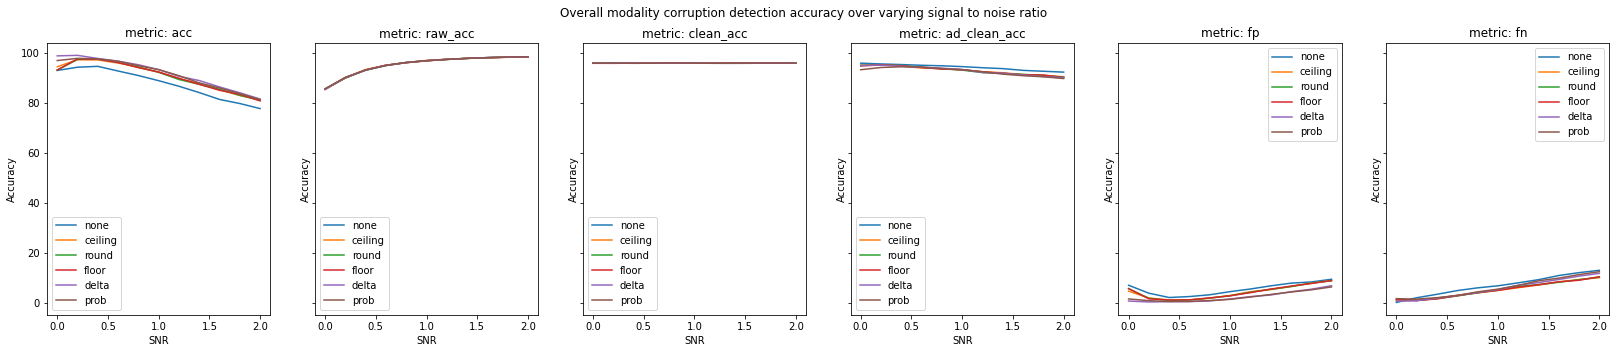

In [86]:
fig, ax = plt.subplots(1, 6, sharey=True, figsize=(28, 5))
rounds = ['none', 'ceiling', 'round', 'floor', 'delta', 'prob']
snrs = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]

for row, metric in enumerate([acc, raw_acc, clean_acc, ad_clean_acc, fp, fn]):
    for rounding in range(len(rounds)):
        ax[row].plot(snrs, np.mean(np.array([[100*metric[rounding][x][corrupt] for x in range(11)] for corrupt in range(3)]), axis=0))
    ax[row].legend(rounds)
    ax[row].set_xlabel('SNR')
    ax[row].set_ylabel('Accuracy')
    ax[row].set_title('metric: {}'.format(['acc', 'raw_acc', 'clean_acc', 'ad_clean_acc', 'fp', 'fn'][row]))
plt.suptitle('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

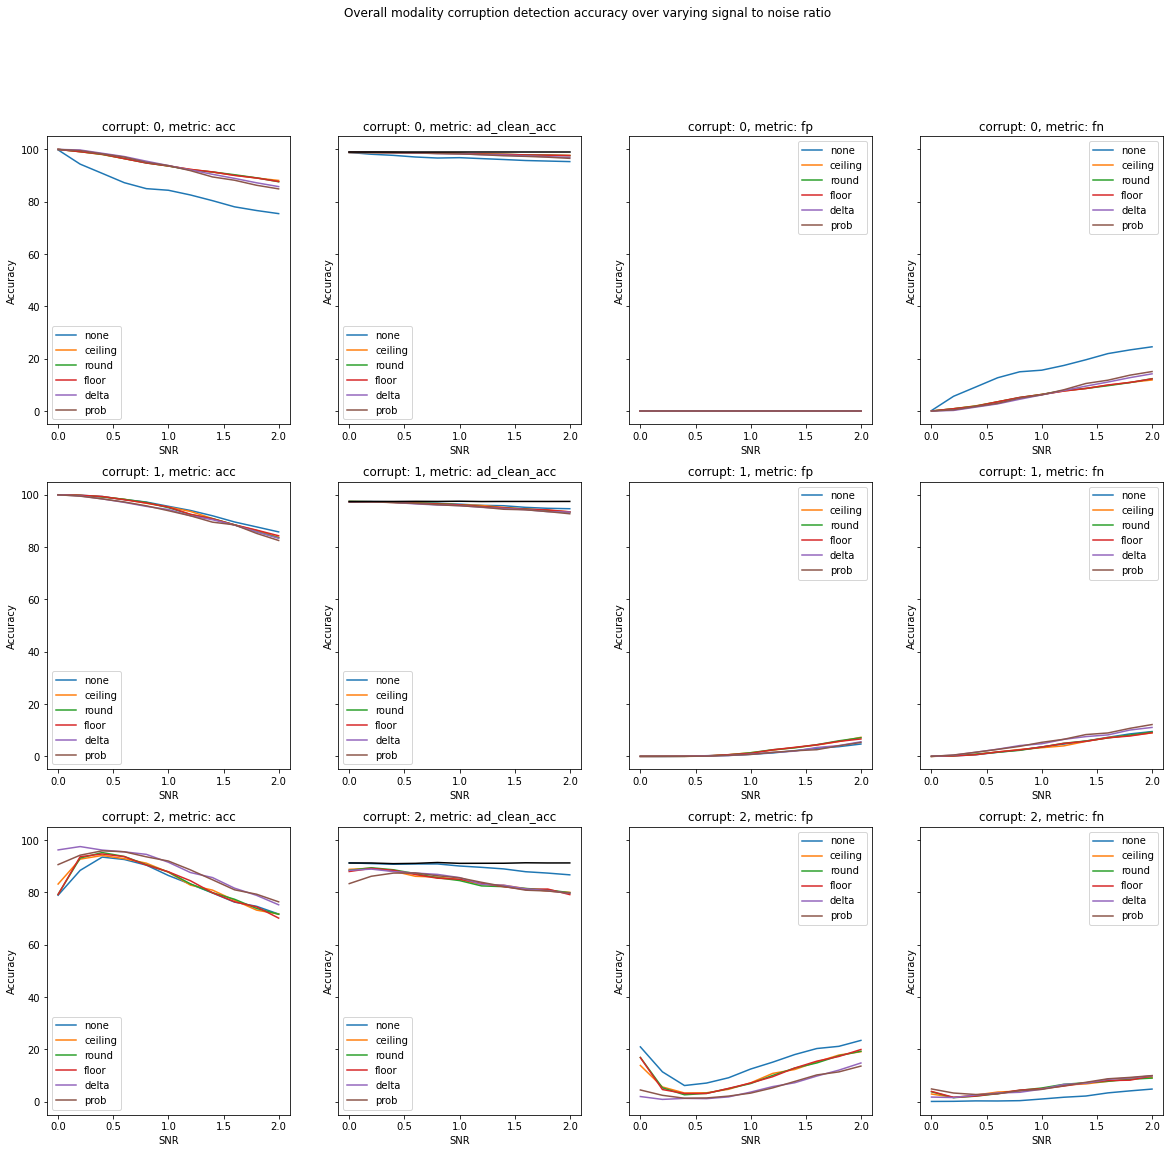

In [87]:
fig, ax = plt.subplots(3, 4, sharey=True, figsize=(20, 18))
rounds = ['none', 'ceiling', 'round', 'floor', 'delta', 'prob']
snrs = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]

for row, metric in enumerate([acc, ad_clean_acc, fp, fn]):
    for corrupt in range(3):
        for rounding in range(len(rounds)):
            ax[corrupt, row].plot(snrs, [100*metric[rounding][x][corrupt] for x in range(11)])
        if row == 1:
            ax[corrupt, row].plot(snrs, [100*clean_acc[rounding][x][corrupt] for x in range(11)], c='black')
        ax[corrupt, row].legend(rounds)
        ax[corrupt, row].set_xlabel('SNR')
        ax[corrupt, row].set_ylabel('Accuracy')
        ax[corrupt, row].set_title('corrupt: {}, metric: {}'.format(corrupt, ['acc', 'ad_clean_acc', 'fp', 'fn'][row]))
plt.suptitle('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

In [90]:
noise_type = 'gmm'
suffix = ''
seed=0
train_snr=0.65 
repeats=1   
acc = []
raw_acc = []
clean_acc = []
ad_clean_acc = []
fp = []
fn = []
thresh_method = 'intersection'
for batch_size in [128]:
    for x, round_func in enumerate(['none', 'ceiling', 'round', 'floor', 'delta', 'prob']):
        acc.append([])
        raw_acc.append([])
        clean_acc.append([])
        ad_clean_acc.append([])
        fp.append([])
        fn.append([])
        for y, thresh_method in enumerate(['intersection', 'noise_mean', 0.1, 0.2, 0.3, 0.4]):
            acc[x].append([])
            raw_acc[x].append([])
            clean_acc[x].append([])
            ad_clean_acc[x].append([])
            fp[x].append([])
            fn[x].append([])
            for snr in [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]:
                for gmm_components in [5]:
                    for cca_dim in [15]:
                        for window_size in [30]:
                            for grace in [0]:
                                sum_acc = np.array([0,0,0], dtype='float64')
                                sum_raw = np.array([0,0,0], dtype='float64')
                                sum_clean = np.array([0,0,0], dtype='float64')
                                sum_ad_clean = np.array([0,0,0], dtype='float64')
                                sum_fp = np.array([0,0,0], dtype='float64')
                                sum_fn = np.array([0,0,0], dtype='float64')
                                for repeat in range(repeats):
                                    with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}_{}_{}{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace, noise_type, thresh_method, suffix, repeat, snr, round_func), 'rb') as f:
                                        res = pickle.load(f)
                                    sum_acc += [get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                                    sum_raw += [res[ncorr]['raw'] for ncorr in [0,1,2]]
                                    sum_clean += [res[ncorr]['clean'] for ncorr in [0,1,2]]
                                    sum_ad_clean += [res[ncorr]['ad_clean'] for ncorr in [0,1,2]]
                                    sum_fp += [res[ncorr]['ad'][0,2]/np.sum(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                                    sum_fn += [res[ncorr]['ad'][0,3]/np.sum(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                                acc[x][y].append(sum_acc/repeats)
                                raw_acc[x][y].append(sum_raw/repeats)
                                clean_acc[x][y].append(sum_clean/repeats)
                                ad_clean_acc[x][y].append(sum_ad_clean/repeats)
                                fp[x][y].append(sum_fp/repeats)
                                fn[x][y].append(sum_fn/repeats)

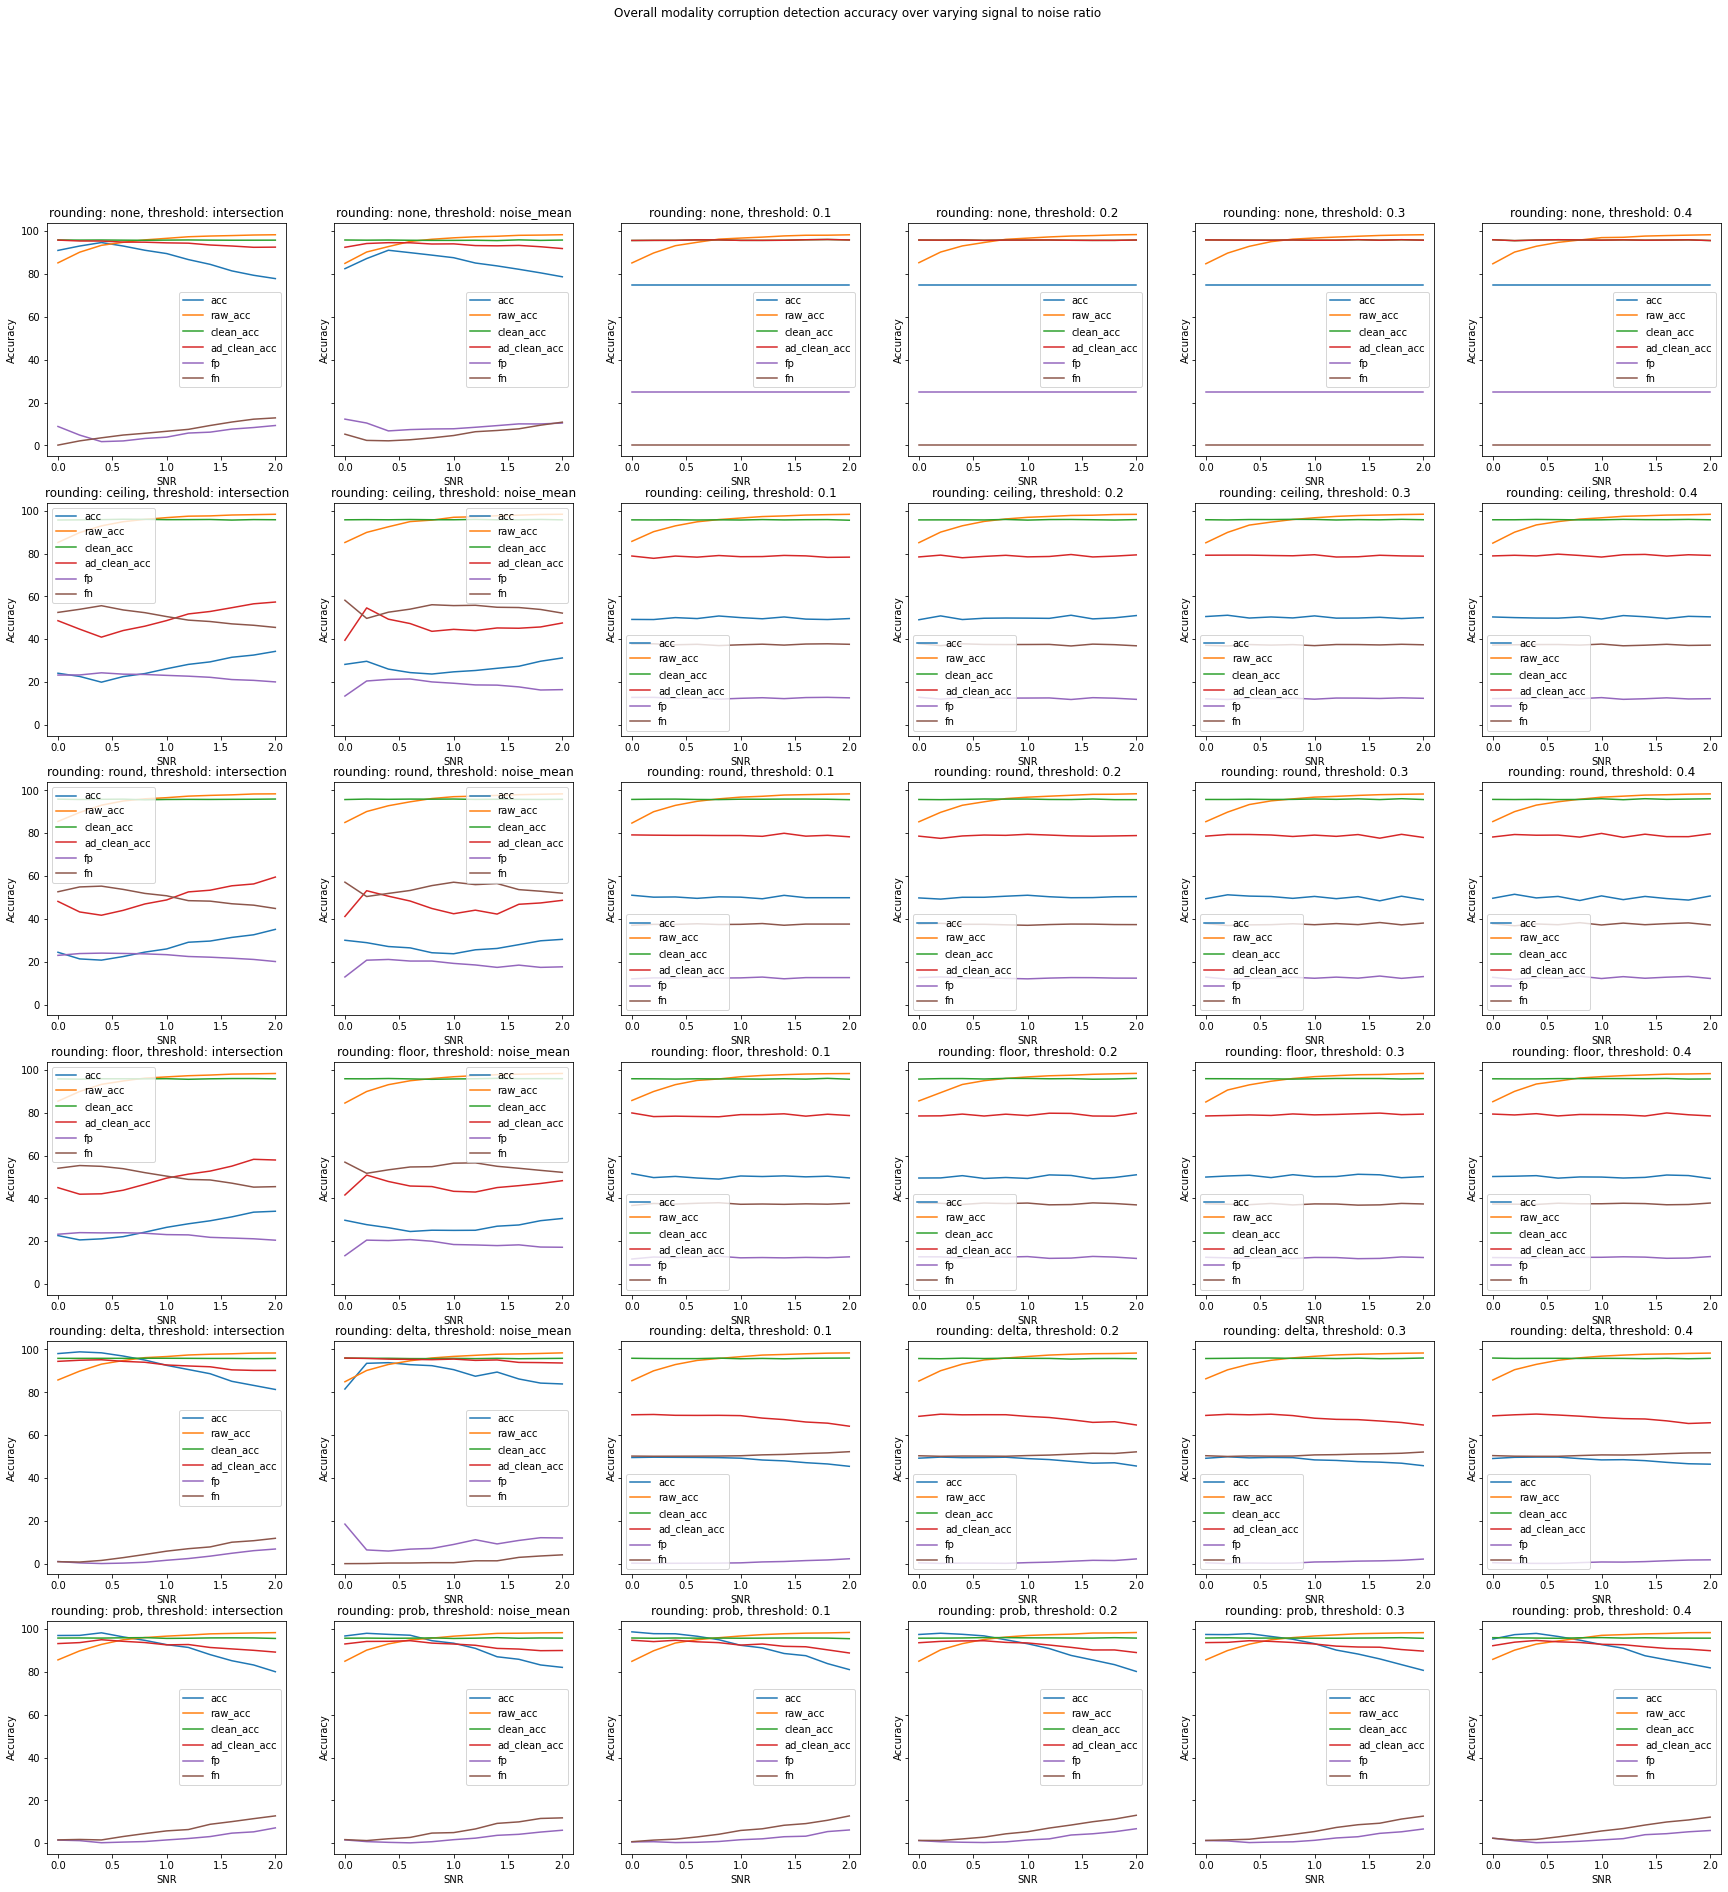

In [94]:
rounds = ['none', 'ceiling', 'round', 'floor', 'delta', 'prob']
threshes = ['intersection', 'noise_mean', 0.1, 0.2, 0.3, 0.4]
snrs = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
metrics = [acc, raw_acc, clean_acc, ad_clean_acc, fp, fn]
fig, ax = plt.subplots(len(rounds), len(threshes), sharey=True, figsize=(30, 30))

for row, rounding in enumerate(rounds):
    for col, thresh in enumerate(threshes):
        for metric in metrics:
            ax[row, col].plot(snrs, np.mean(np.array([[100*metric[row][col][x][corr] for x in range(11)] for corr in range(3)]), axis=0))
        ax[row, col].legend(['acc', 'raw_acc', 'clean_acc', 'ad_clean_acc', 'fp', 'fn'])
        ax[row, col].set_xlabel('SNR')
        ax[row, col].set_ylabel('Accuracy')
        ax[row, col].set_title('rounding: {}, threshold: {}'.format(rounding, thresh))
plt.suptitle('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

In [10]:
repeats = 5
acc = []
raw_acc = []
clean_acc = []
ad_clean_acc = []
for noise_type in ['gmm']:#'gaussian', 'gmm', 'mod', 'full']:
    for ad_classifier in ['delta']:#'ceiling', 'round', 'floor', 'delta', 'none']:
        for thresh_method in ['intersection']:#['ppf', 'noise_mean', 0.1, 0.2, 0.3, 0.4]:
            for thresh_method_param in [1.0]:#[0.01, 0.05, 0.1, 0.15, 0.2, 0.3]:
                for batch_size in [128]:
                    for x, snr in enumerate([0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]):
                        acc.append([])
                        raw_acc.append([])
                        clean_acc.append([])
                        ad_clean_acc.append([])
                        for gmm_components in [5]:
                            for cca_dim in [15]:
                                for window_size in [30]:
                                    for grace in [0]:
                                        for train_snr in [snr]:
                                            for cca_weighting in ['mean']:#, 'flat']:
                                                sum_acc = np.array([0,0,0], dtype='float64')
                                                sum_raw = np.array([0,0,0], dtype='float64')
                                                sum_clean = np.array([0,0,0], dtype='float64')
                                                sum_ad_clean = np.array([0,0,0], dtype='float64')
                                                for repeat in range(repeats):
                                                    with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace, noise_type, thresh_method, thresh_method_param, repeat, train_snr, ad_classifier, cca_weighting), 'rb') as f:
                                                        res = pickle.load(f)
                                                    sum_acc += [get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                                                    sum_raw += [res[ncorr]['raw'] for ncorr in [0,1,2]]
                                                    sum_clean += [res[ncorr]['clean'] for ncorr in [0,1,2]]
                                                    sum_ad_clean += [res[ncorr]['ad_clean'] for ncorr in [0,1,2]]

                                                acc[x].append(sum_acc/repeats)
                                                raw_acc[x].append(sum_raw/repeats)
                                                clean_acc[x].append(sum_clean/repeats)
                                                ad_clean_acc[x].append(sum_ad_clean/repeats)

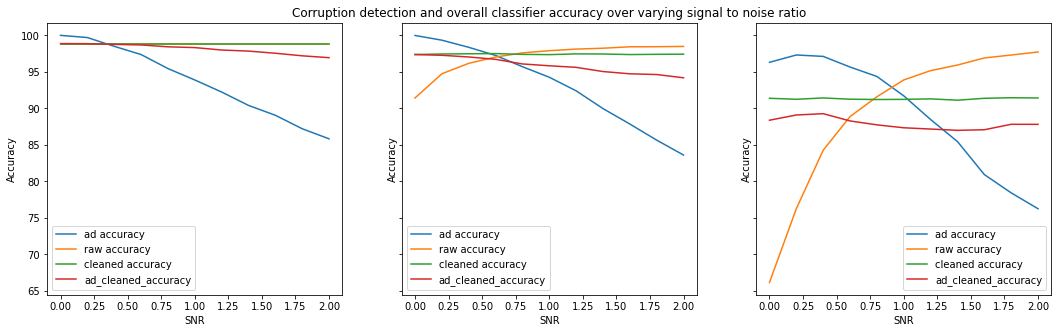

In [11]:
snrs = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot(snrs, [100*acc[snr][0][ax_idx] for snr in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*raw_acc[snr][0][ax_idx] for snr in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*clean_acc[snr][0][ax_idx] for snr in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*ad_clean_acc[snr][0][ax_idx] for snr in range(len(snrs))])
    ax[ax_idx].legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad_cleaned_accuracy'])
    ax[ax_idx].set_xlabel('SNR')
    ax[ax_idx].set_ylabel('Accuracy')
ax[1].set_title('Corruption detection and overall classifier accuracy over varying signal to noise ratio')
plt.show()

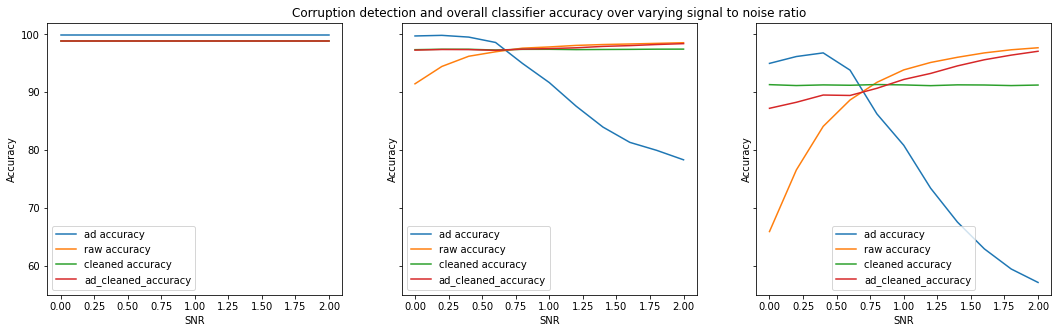

In [28]:
repeats = 5
acc = []
raw_acc = []
clean_acc = []
ad_clean_acc = []
for noise_type in ['gmm']:#'gaussian', 'gmm', 'mod', 'full']:
    for ad_classifier in ['delta']:#'ceiling', 'round', 'floor', 'delta', 'none']:
        for thresh_method in ['ppf']:#['intersection', 'noise_mean', 0.1, 0.2, 0.3, 0.4]:
            for thresh_method_param in [0.01]:#[0.01, 0.05, 0.1, 0.15, 0.2, 0.3]:
                for batch_size in [128]:
                    for x, snr in enumerate([0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]):
                        acc.append([])
                        raw_acc.append([])
                        clean_acc.append([])
                        ad_clean_acc.append([])
                        for gmm_components in [5]:
                            for cca_dim in [15]:
                                for window_size in [30]:
                                    for grace in [0]:
                                        for train_snr in [snr]:
                                            for cca_weighting in ['mean']:#, 'flat']:
                                                sum_acc = np.array([0,0,0], dtype='float64')
                                                sum_raw = np.array([0,0,0], dtype='float64')
                                                sum_clean = np.array([0,0,0], dtype='float64')
                                                sum_ad_clean = np.array([0,0,0], dtype='float64')
                                                for repeat in range(repeats):
                                                    with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace, noise_type, thresh_method, thresh_method_param, repeat, train_snr, ad_classifier, cca_weighting), 'rb') as f:
                                                        res = pickle.load(f)
                                                    sum_acc += [get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                                                    sum_raw += [res[ncorr]['raw'] for ncorr in [0,1,2]]
                                                    sum_clean += [res[ncorr]['clean'] for ncorr in [0,1,2]]
                                                    sum_ad_clean += [res[ncorr]['ad_clean'] for ncorr in [0,1,2]]

                                                acc[x].append(sum_acc/repeats)
                                                raw_acc[x].append(sum_raw/repeats)
                                                clean_acc[x].append(sum_clean/repeats)
                                                ad_clean_acc[x].append(sum_ad_clean/repeats)

snrs = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot(snrs, [100*acc[snr][0][ax_idx] for snr in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*raw_acc[snr][0][ax_idx] for snr in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*clean_acc[snr][0][ax_idx] for snr in range(len(snrs))])
    ax[ax_idx].plot(snrs, [100*ad_clean_acc[snr][0][ax_idx] for snr in range(len(snrs))])
    ax[ax_idx].legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad_cleaned_accuracy'])
    ax[ax_idx].set_xlabel('SNR')
    ax[ax_idx].set_ylabel('Accuracy')
ax[1].set_title('Corruption detection and overall classifier accuracy over varying signal to noise ratio')
plt.show()

[[0.0019319578644262712], [0.0036519392085995247], [0.0023400740195316993], [0.0026980644588475468], [0.006441890592897978], [0.005647899222941185], [0.002042876039235114], [0.0019084760725663215], [0.0026606674394398706], [0.0012819067542408414], [0.0009009009009009398]]


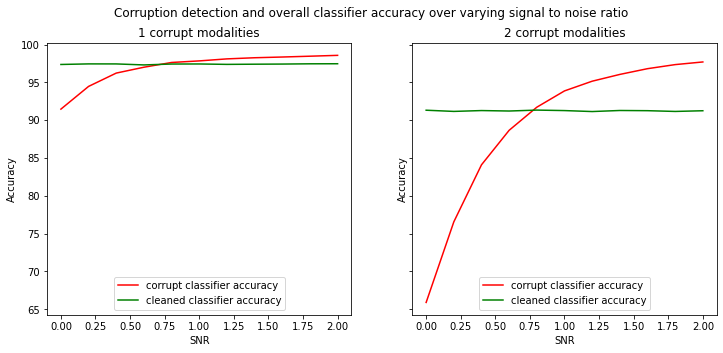

In [41]:
repeats = 5
acc = []
raw_acc = []
clean_acc = []
ad_clean_acc = []

acc_std = []
raw_acc_std = []
clean_acc_std = []
ad_clean_acc_std = []
for noise_type in ['gmm']:#'gaussian', 'gmm', 'mod', 'full']:
    for ad_classifier in ['delta']:#'ceiling', 'round', 'floor', 'delta', 'none']:
        for thresh_method in ['ppf']:#['intersection', 'noise_mean', 0.1, 0.2, 0.3, 0.4]:
            for thresh_method_param in [0.01]:#[0.01, 0.05, 0.1, 0.15, 0.2, 0.3]:
                for batch_size in [128]:
                    for x, snr in enumerate([0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]):
                        acc.append([])
                        raw_acc.append([])
                        clean_acc.append([])
                        ad_clean_acc.append([])
                        acc_std.append([])
                        raw_acc_std.append([])
                        clean_acc_std.append([])
                        ad_clean_acc_std.append([])
                        for gmm_components in [5]:
                            for cca_dim in [15]:
                                for window_size in [30]:
                                    for grace in [0]:
                                        for train_snr in [snr]:
                                            for cca_weighting in ['mean']:#, 'flat']:
                                                sum_acc = np.array([0,0,0], dtype='float64')
                                                sum_raw = np.array([0,0,0], dtype='float64')
                                                sum_clean = np.array([0,0,0], dtype='float64')
                                                sum_ad_clean = np.array([0,0,0], dtype='float64')
                                                accs = []
                                                raws = []
                                                cleans = []
                                                ad_cleans = []
                                                for repeat in range(repeats):
                                                    with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace, noise_type, thresh_method, thresh_method_param, repeat, train_snr, ad_classifier, cca_weighting), 'rb') as f:
                                                        res = pickle.load(f)
                                                    sum_acc += [get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                                                    sum_raw += [res[ncorr]['raw'] for ncorr in [0,1,2]]
                                                    sum_clean += [res[ncorr]['clean'] for ncorr in [0,1,2]]
                                                    sum_ad_clean += [res[ncorr]['ad_clean'] for ncorr in [0,1,2]]
                                                    
                                                    accs.append(np.mean([get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]))
                                                    raws.append(np.mean([res[ncorr]['raw'] for ncorr in [0,1,2]]))
                                                    cleans.append(np.mean([res[ncorr]['clean'] for ncorr in [0,1,2]]))
                                                    ad_cleans.append(np.mean([res[ncorr]['ad_clean'] for ncorr in [0,1,2]]))

                                                acc[x].append(sum_acc/repeats)
                                                raw_acc[x].append(sum_raw/repeats)
                                                clean_acc[x].append(sum_clean/repeats)
                                                ad_clean_acc[x].append(sum_ad_clean/repeats)

                                                acc_std[x].append(np.std(accs))
                                                raw_acc_std[x].append(np.std(raws))
                                                clean_acc_std[x].append(np.std(cleans))
                                                ad_clean_acc_std[x].append(np.std(ad_cleans))

snrs = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
fig, ax = plt.subplots(1,2, sharey=True, figsize=(12, 5))
for ax_idx in range(2):
    ax[ax_idx].plot(snrs, [100*raw_acc[snr][0][ax_idx+1] for snr in range(len(snrs))], c='red')
    ax[ax_idx].plot(snrs, [100*raw_acc[snr][0][ax_idx+1] for snr in range(len(snrs))], c='red')
    ax[ax_idx].plot(snrs, [100*clean_acc[snr][0][ax_idx+1] for snr in range(len(snrs))], c='green')
    ax[ax_idx].legend(['corrupt classifier accuracy', 'cleaned classifier accuracy'], loc='lower center')
    ax[ax_idx].set_xlabel('SNR')
    ax[ax_idx].set_ylabel('Accuracy')
    ax[ax_idx].set_title('{} corrupt modalities'.format(ax_idx+1))
fig.suptitle('Corruption detection and overall classifier accuracy over varying signal to noise ratio')
plt.show()

[0.9809142475809143,
 0.9820153486820153,
 0.981614948281615,
 0.9816816816816818,
 0.9802802802802804]

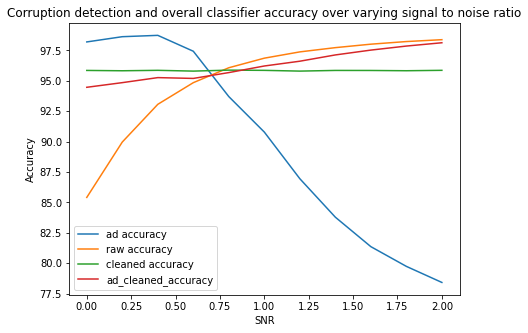

In [27]:
repeats = 5
acc = []
raw_acc = []
clean_acc = []
ad_clean_acc = []
for noise_type in ['gmm']:#'gaussian', 'gmm', 'mod', 'full']:
    for ad_classifier in ['delta']:#'ceiling', 'round', 'floor', 'delta', 'none']:
        for thresh_method in ['ppf']:#['intersection', 'noise_mean', 0.1, 0.2, 0.3, 0.4]:
            for thresh_method_param in [0.01]:#[0.01, 0.05, 0.1, 0.15, 0.2, 0.3]:
                for batch_size in [128]:
                    for x, snr in enumerate([0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]):
                        acc.append([])
                        raw_acc.append([])
                        clean_acc.append([])
                        ad_clean_acc.append([])
                        for gmm_components in [5]:
                            for cca_dim in [15]:
                                for window_size in [30]:
                                    for grace in [0]:
                                        for train_snr in [snr]:
                                            for cca_weighting in ['mean']:#, 'flat']:
                                                sum_acc = np.array([0,0,0], dtype='float64')
                                                sum_raw = np.array([0,0,0], dtype='float64')
                                                sum_clean = np.array([0,0,0], dtype='float64')
                                                sum_ad_clean = np.array([0,0,0], dtype='float64')
                                                for repeat in range(repeats):
                                                    with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace, noise_type, thresh_method, thresh_method_param, repeat, train_snr, ad_classifier, cca_weighting), 'rb') as f:
                                                        res = pickle.load(f)
                                                    sum_acc += [get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                                                    sum_raw += [res[ncorr]['raw'] for ncorr in [0,1,2]]
                                                    sum_clean += [res[ncorr]['clean'] for ncorr in [0,1,2]]
                                                    sum_ad_clean += [res[ncorr]['ad_clean'] for ncorr in [0,1,2]]

                                                acc[x].append(sum_acc/repeats)
                                                raw_acc[x].append(sum_raw/repeats)
                                                clean_acc[x].append(sum_clean/repeats)
                                                ad_clean_acc[x].append(sum_ad_clean/repeats)

snrs = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
fig, ax = plt.subplots(1,1, sharey=True, figsize=(7, 5))
ax.plot(snrs, np.mean(np.array([[100*acc[snr][0][i] for snr in range(len(snrs))] for i in range(3)]), axis=0))
ax.plot(snrs, np.mean(np.array([[100*raw_acc[snr][0][i] for snr in range(len(snrs))] for i in range(3)]), axis=0))
ax.plot(snrs, np.mean(np.array([[100*clean_acc[snr][0][i] for snr in range(len(snrs))] for i in range(3)]), axis=0))
ax.plot(snrs, np.mean(np.array([[100*ad_clean_acc[snr][0][i] for snr in range(len(snrs))] for i in range(3)]), axis=0))
ax.legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad_cleaned_accuracy'])
ax.set_xlabel('SNR')
ax.set_ylabel('Accuracy')
ax.set_title('Corruption detection and overall classifier accuracy over varying signal to noise ratio')
plt.show()

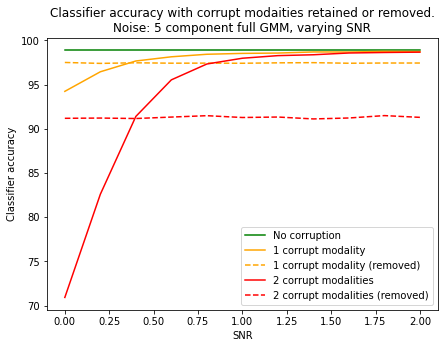

In [48]:
repeats = 5
acc = []
raw_acc = []
clean_acc = []
ad_clean_acc = []
for noise_type in ['full']:#'gaussian', 'gmm', 'mod', 'full']:
    for ad_classifier in ['delta']:#'ceiling', 'round', 'floor', 'delta', 'none']:
        for thresh_method in ['intersection']:#['intersection', 'noise_mean', 0.1, 0.2, 0.3, 0.4]:
            for thresh_method_param in [0.01]:#[0.01, 0.05, 0.1, 0.15, 0.2, 0.3]:
                for batch_size in [128]:
                    for x, snr in enumerate([0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]):
                        acc.append([])
                        raw_acc.append([])
                        clean_acc.append([])
                        ad_clean_acc.append([])
                        for gmm_components in [5]:
                            for cca_dim in [15]:
                                for window_size in [30]:
                                    for grace in [0]:
                                        for train_snr in [snr]:
                                            for cca_weighting in ['mean']:#, 'flat']:
                                                sum_acc = np.array([0,0,0], dtype='float64')
                                                sum_raw = np.array([0,0,0], dtype='float64')
                                                sum_clean = np.array([0,0,0], dtype='float64')
                                                sum_ad_clean = np.array([0,0,0], dtype='float64')
                                                for repeat in range(repeats):
                                                    with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace, noise_type, thresh_method, thresh_method_param, repeat, train_snr, ad_classifier, cca_weighting), 'rb') as f:
                                                        res = pickle.load(f)
                                                    sum_acc += [get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]]
                                                    sum_raw += [res[ncorr]['raw'] for ncorr in [0,1,2]]
                                                    sum_clean += [res[ncorr]['clean'] for ncorr in [0,1,2]]
                                                    sum_ad_clean += [res[ncorr]['ad_clean'] for ncorr in [0,1,2]]

                                                acc[x].append(sum_acc/repeats)
                                                raw_acc[x].append(sum_raw/repeats)
                                                clean_acc[x].append(sum_clean/repeats)
                                                ad_clean_acc[x].append(sum_ad_clean/repeats)

corr = 0
snrs = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
fig, ax = plt.subplots(1,1, sharey=True, figsize=(7, 5))
#ax.plot(snrs, [100*acc[snr][0][corr] for snr in range(len(snrs))])
for corr, color in enumerate(['green', 'orange', 'red']):
    ax.plot(snrs, [100*raw_acc[snr][0][corr] for snr in range(len(snrs))], c=color)
    if corr > 0:
        ax.plot(snrs, [100*clean_acc[snr][0][corr] for snr in range(len(snrs))], c=color, linestyle='dashed')
#ax.plot(snrs, [100*ad_clean_acc[snr][0][corr] for snr in range(len(snrs))])
ax.legend(['No corruption', '1 corrupt modality', '1 corrupt modality (removed)', '2 corrupt modalities', '2 corrupt modalities (removed)'])
ax.set_xlabel('SNR')
ax.set_ylabel('Classifier accuracy')
ax.set_title('Classifier accuracy with corrupt modaities retained or removed.\nNoise: 5 component full GMM, varying SNR')
plt.show()